# Multi Color Light Curves  applied LSSTComCamSim : DZP on CCD


- author Sylvie Dagoret-Campagne
- creation date 2024-05-03
- last update 2024-05-03


  
``Quantum Graphs``: https://tigress-web.princeton.edu/~lkelvin/pipelines/ 


https://tigress-web.princeton.edu/~lkelvin/pipelines/current/drp_pipe/LSSTComCamSim/nightly-validation-ops-rehearsal-3/

``CalibrateTask``: 
https://github.com/lsst/pipe_tasks/blob/main/python/lsst/pipe/tasks/calibrate.py#L392-L399


``Shemas``:
https://dm.lsst.org/sdm_schemas/browser/

In [1]:
from lsst.daf.butler import Butler

import astropy.units as u
import numpy as np 
import pandas as pd
pd.set_option("display.max_columns", None)
from astropy.time import Time

import scipy.stats

import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm

import lsst.afw.display.rgb as afwRgb
import lsst.afw.image as afwImage
import lsst.geom as geom
import pickle
from astropy.stats import SigmaClip

In [2]:
#xx-small
#x-small
#small
#medium
#large
#x-large
#xx-large

plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams["axes.labelsize"] = 'x-large'
plt.rcParams['axes.titlesize'] = 'x-large'
plt.rcParams['xtick.labelsize']= 'x-large'
plt.rcParams['ytick.labelsize']= 'x-large'

In [3]:
from shapely.geometry import Point as shapelyPoint
from shapely.geometry.polygon import Polygon as shapelyPolygon

In [4]:
def is_in_polygon(x,y,ll,lr,ur,ul):
    point = shapelyPoint(x, y)
    polygon = shapelyPolygon([ll, lr, ur, ul])
    return polygon.contains(point)

In [5]:
def angle_in_range(alpha, lower, upper):
    return (alpha - lower) % 360 <= (upper - lower) % 360

In [6]:
def isradec_inbbox_radec(ra,dec,ramin,ramax,decmin,decmax):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    ra: ra in degree
    dec: dec in degree
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    Bool
    
    """


    flag_ra = angle_in_range(ra,ramin,ramax)
    flag_dec = angle_in_range(dec,decmin,decmax)

    flag = flag_ra and flag_dec
    return flag


In [7]:
def get_corners_radec(wcs, bbox):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    corners_ra, corners_dec in decimal degrees
    """

    corners_x = [bbox.beginX, bbox.beginX, bbox.endX, bbox.endX]
    corners_y = [bbox.beginY, bbox.endY, bbox.endY, bbox.beginY]
    corners_ra = []
    corners_dec = []
    for i in range(4):
        radec = wcs.pixelToSky(corners_x[i], corners_y[i])
        corners_ra.append(radec.getRa().asDegrees())
        corners_dec.append(radec.getDec().asDegrees())
    
    return corners_ra, corners_dec

In [8]:
saveDir = "./lc_output_dmrehearsal2024"
doSaveFigs = False  # set to True if you actually want to save the figures in the above dir

In [9]:
# Set some selections for reliable data
minNumMatches = 3
minSnCalibFlux =  100

In [10]:
# INSERT YOUR collection and tract
# for rehearsal use collection 2 which have CCDvisit
butlerRoot = "/repo/embargo"

collection1 = 'LSSTComCamSim/runs/nightlyvalidation/20240402/d_2024_03_29/DM-43612'
collection2 = 'LSSTComCamSim/runs/nightlyvalidation/20240403/d_2024_03_29/DM-43612'
collection3 = 'LSSTComCamSim/runs/nightlyvalidation/20240404/d_2024_03_29/DM-43612'
collectionn = 'LSSTComCamSim/runs/nightlyvalidation/20240403/d_2024_03_29/DM-43612'
#collections = [collection1,collection2,collection3]
collections = [collection2]
collectionStr = collectionn.replace("/", "_")
instrument = 'LSSTComCamSim'
skymapName = "ops_rehersal_prep_2k_v1"
where_clause = "instrument = \'" + instrument+ "\'"
#3533 : No matching visitId
tract = 2494
#tract = 7445
#tract = 9880
#band = "r"
suptitle = collectionStr + f" inst = {instrument} tract = {tract}"

calibFluxStr = "apFlux_12_0_instFlux"
calibFluxErrStr = "apFlux_12_0_instFluxErr"
calibFluxMagStr = "apFlux_12_0_instMag"
calibFluxMagErrStr = "apFlux_12_0_instMagErr"

calibFluxCalStr = "apFlux_12_0_calFlux"
calibFluxCalErrStr = "apFlux_12_0_calFluxErr"
calibFluxCalMagStr = "apFlux_12_0_calMag"
calibFluxCalMagErrStr = "apFlux_12_0_calMagErr"

file_output_selectedsources = f"lightcurves-dmrehearsal2024_04_03_tract{tract}.csv"
fullname_file_output_selectedsources = os.path.join(saveDir,file_output_selectedsources)

## Initiate butler from variables set above

In [11]:
# Initiate butler from variables set above
butler = Butler(butlerRoot, collections=collections, instrument=instrument, skymap=skymapName)
camera = butler.get("camera", instrument=instrument)
skymap = butler.get("skyMap")
print("camera_name = {}".format(camera.getName()))
print("collections = {}".format(collections))

camera_name = LSSTComCamSim
collections = ['LSSTComCamSim/runs/nightlyvalidation/20240403/d_2024_03_29/DM-43612']


## load isolated_star_sources

In [12]:
# Try to get the Schema
all_tracts = []
data_product = "isolated_star_sources"
datasetRefs = butler.registry.queryDatasets(datasetType=data_product, collections=collections, where= where_clause)
for i, ref in enumerate(datasetRefs):
    print(i,ref.dataId)
    all_tracts.append(ref.dataId["tract"])
    #butler_data = butler.get(ref)

all_tracts = sorted(all_tracts)
print("all tracts : ", all_tracts)

#if not isinstance(butler_data, pd.core.frame.DataFrame):
#    print(butler_data.getSchema())

0 {instrument: 'LSSTComCamSim', skymap: 'ops_rehersal_prep_2k_v1', tract: 2494}
1 {instrument: 'LSSTComCamSim', skymap: 'ops_rehersal_prep_2k_v1', tract: 2495}
2 {instrument: 'LSSTComCamSim', skymap: 'ops_rehersal_prep_2k_v1', tract: 2661}
3 {instrument: 'LSSTComCamSim', skymap: 'ops_rehersal_prep_2k_v1', tract: 2662}
4 {instrument: 'LSSTComCamSim', skymap: 'ops_rehersal_prep_2k_v1', tract: 3200}
5 {instrument: 'LSSTComCamSim', skymap: 'ops_rehersal_prep_2k_v1', tract: 3345}
6 {instrument: 'LSSTComCamSim', skymap: 'ops_rehersal_prep_2k_v1', tract: 3346}
7 {instrument: 'LSSTComCamSim', skymap: 'ops_rehersal_prep_2k_v1', tract: 3533}
8 {instrument: 'LSSTComCamSim', skymap: 'ops_rehersal_prep_2k_v1', tract: 3534}
9 {instrument: 'LSSTComCamSim', skymap: 'ops_rehersal_prep_2k_v1', tract: 6914}
10 {instrument: 'LSSTComCamSim', skymap: 'ops_rehersal_prep_2k_v1', tract: 6915}
11 {instrument: 'LSSTComCamSim', skymap: 'ops_rehersal_prep_2k_v1', tract: 7148}
12 {instrument: 'LSSTComCamSim', skyma

## isolated_star_sources Keeping all bands here, but keep the tract selection

The main starting point is the table of isolated_star_sources which has been constructed in step 2a from a catalog
Note that isolated star sources are associated to an object (a static starobject)
Here the work is doneband by band.
It is a good idea to work band by band.

In [13]:
# Load in isolated_star_sources and trim to band of interest and select the tract
isolatedStarSourcesFull = butler.get("isolated_star_sources", tract=tract)
#isolatedStarSourcesFull = isolatedStarSourcesFull[isolatedStarSourcesFull["band"] == band]

In [14]:
tract

2494

In [15]:
len(isolatedStarSourcesFull)

664704

In [16]:
# Just to have a look at what's in the catalog:
isolatedStarSourcesFull[isolatedStarSourcesFull.index == 0]

,index,sourceId,visit,detector,ra,dec,physical_filter,band,apFlux_12_0_instFlux,apFlux_12_0_instFluxErr,x,y,xErr,yErr,apFlux_17_0_instFlux,apFlux_17_0_instFluxErr,apFlux_17_0_flag,localBackground_instFlux,localBackground_flag,ixx,iyy,ixy,source_row,obj_index
0,99325,3065474226484936866,7024040300581,7,279.868189,-48.063642,i_06,i,20825.896484,621.281189,3656.229531,69.944283,0.022153,0.022196,20419.768999,879.22988,False,0.239154,False,1.825126,1.816471,0.009507,99325,0


In [17]:
isolatedStarSourcesFull.head()

,index,sourceId,visit,detector,ra,dec,physical_filter,band,apFlux_12_0_instFlux,apFlux_12_0_instFluxErr,x,y,xErr,yErr,apFlux_17_0_instFlux,apFlux_17_0_instFluxErr,apFlux_17_0_flag,localBackground_instFlux,localBackground_flag,ixx,iyy,ixy,source_row,obj_index
0,99325,3065474226484936866,7024040300581,7,279.868189,-48.063642,i_06,i,20825.896484,621.281189,3656.229531,69.944283,0.022153,0.022196,20419.768999,879.229880,False,0.239154,False,1.825126,1.816471,0.009507,99325,0
1,105385,3065474227558684913,7024040300582,7,279.868196,-48.063645,i_06,i,20513.070312,621.842896,1154.947901,2758.247871,0.022588,0.021572,21523.310571,880.180357,False,0.254727,False,1.860208,1.774970,-0.005804,105385,0
2,99478,3065474228632420428,7024040300583,7,279.868183,-48.063642,i_06,i,19191.630859,631.030823,434.090032,36.309856,0.023069,0.023109,18530.540675,894.783943,False,-0.643387,False,1.817381,1.879033,-0.054907,99478,0
3,101480,3065474229706169087,7024040300584,7,279.868186,-48.063643,i_06,i,19648.865234,618.939209,715.767385,3143.944998,0.023796,0.024680,19133.695969,875.697264,False,-0.334094,False,1.933969,2.048853,0.078023,101480,0
4,98012,3065474230779906996,7024040300585,7,279.868187,-48.063643,i_06,i,20019.126953,647.828674,1590.989654,1500.417290,0.027849,0.027534,18883.463567,918.737462,False,-2.123127,False,2.258469,2.286982,0.012919,98012,0


In [18]:
isolatedStarSourcesFull.tail()

,index,sourceId,visit,detector,ra,dec,physical_filter,band,apFlux_12_0_instFlux,apFlux_12_0_instFluxErr,x,y,xErr,yErr,apFlux_17_0_instFlux,apFlux_17_0_instFluxErr,apFlux_17_0_flag,localBackground_instFlux,localBackground_flag,ixx,iyy,ixy,source_row,obj_index
664699,212,3065474223234351317,7024040300578,0,279.064987,-47.880712,g_01,g,17784.931641,447.129883,177.614192,142.160237,0.024478,0.025717,18222.380251,630.131527,False,0.949386,False,2.375214,2.542768,0.199471,212,28599
664700,193,3065474223234351298,7024040300578,0,279.093273,-47.871926,g_01,g,24576.859375,462.928650,553.418365,128.943838,0.019357,0.019739,24368.411690,649.409041,False,0.284536,False,2.427044,2.431681,0.273162,193,28600
664701,185,3065474223234351290,7024040300578,0,279.077563,-47.876195,g_01,g,15114.945312,445.442047,348.959883,126.144155,0.029670,0.029527,15337.927126,627.749099,False,0.547065,False,2.496540,2.521481,0.305903,185,28601
664702,164,3065474223234351269,7024040300578,0,279.097150,-47.869809,g_01,g,120865.101562,521.513184,611.310686,112.018645,0.007122,0.007080,121556.533508,692.685787,False,0.635554,False,2.445363,2.374502,0.244708,164,28602
664703,163,3065474223234351268,7024040300578,0,279.063103,-47.879411,g_01,g,93753.273438,495.451202,165.743269,111.783884,0.008379,0.008220,94105.769127,665.531272,False,0.787353,False,2.513831,2.418630,0.241959,163,28603


In [19]:
isolatedStarSourcesFull.columns

Index(['index', 'sourceId', 'visit', 'detector', 'ra', 'dec',
       'physical_filter', 'band', 'apFlux_12_0_instFlux',
       'apFlux_12_0_instFluxErr', 'x', 'y', 'xErr', 'yErr',
       'apFlux_17_0_instFlux', 'apFlux_17_0_instFluxErr', 'apFlux_17_0_flag',
       'localBackground_instFlux', 'localBackground_flag', 'ixx', 'iyy', 'ixy',
       'source_row', 'obj_index'],
      dtype='object')

In [20]:
print(sorted(isolatedStarSourcesFull["visit"].unique()))

[7024040300541, 7024040300542, 7024040300543, 7024040300544, 7024040300545, 7024040300546, 7024040300547, 7024040300548, 7024040300549, 7024040300550, 7024040300551, 7024040300552, 7024040300554, 7024040300555, 7024040300557, 7024040300558, 7024040300559, 7024040300560, 7024040300561, 7024040300562, 7024040300563, 7024040300564, 7024040300565, 7024040300566, 7024040300567, 7024040300568, 7024040300569, 7024040300570, 7024040300571, 7024040300572, 7024040300573, 7024040300574, 7024040300575, 7024040300576, 7024040300577, 7024040300578, 7024040300579, 7024040300580, 7024040300581, 7024040300582, 7024040300583, 7024040300584, 7024040300585, 7024040300586, 7024040300587, 7024040300588, 7024040300589, 7024040300590, 7024040300591, 7024040300592, 7024040300593, 7024040300594, 7024040300595, 7024040300596, 7024040300597, 7024040300598, 7024040300599, 7024040300600, 7024040300662, 7024040300663, 7024040300665, 7024040300666, 7024040300667, 7024040300668, 7024040300669, 7024040300670, 702404030

In [21]:
# Just to have a look at what's in the catalog:
isolatedStarSourcesFull[isolatedStarSourcesFull.index == 0]

,index,sourceId,visit,detector,ra,dec,physical_filter,band,apFlux_12_0_instFlux,apFlux_12_0_instFluxErr,x,y,xErr,yErr,apFlux_17_0_instFlux,apFlux_17_0_instFluxErr,apFlux_17_0_flag,localBackground_instFlux,localBackground_flag,ixx,iyy,ixy,source_row,obj_index
0,99325,3065474226484936866,7024040300581,7,279.868189,-48.063642,i_06,i,20825.896484,621.281189,3656.229531,69.944283,0.022153,0.022196,20419.768999,879.22988,False,0.239154,False,1.825126,1.816471,0.009507,99325,0


In [22]:
print("calibFluxStr = {},,minSnCalibFlux = {}, minNumMatches = {}".format(calibFluxStr,minSnCalibFlux,minNumMatches))

calibFluxStr = apFlux_12_0_instFlux,,minSnCalibFlux = 100, minNumMatches = 3


## Statistics on detectors in isolated_star_sources

In [23]:
ser_isolatedstar_perdetectorband_size = isolatedStarSourcesFull.groupby(["detector","band"]).size()

In [24]:
ser_isolatedstar_perdetectorband_size

detector  band
0         g       44031
          i       43982
          r       69377
1         g       12420
          i       13818
          r       39064
2         g        1028
          i          37
          r        5755
3         g       51688
          i       61921
          r       55460
4         g        9421
          i       17733
          r       19317
5         g          60
          i          11
          r         166
6         g       51383
          i       70175
          r       36782
7         g       18417
          i       32574
          r        5870
8         g         904
          i        3310
dtype: int64

In [25]:
df_isolatedstar_perdetectorband = ser_isolatedstar_perdetectorband_size.unstack(level=1)
df_isolatedstar_perdetectorband 

band,g,i,r
detector,,,
0,44031.0,43982.0,69377.0
1,12420.0,13818.0,39064.0
2,1028.0,37.0,5755.0
3,51688.0,61921.0,55460.0
4,9421.0,17733.0,19317.0
5,60.0,11.0,166.0
6,51383.0,70175.0,36782.0
7,18417.0,32574.0,5870.0
8,904.0,3310.0,NaN


<Axes: title={'center': 'Number of isolated sources per detector and per filter in tract 2494'}, xlabel='detector'>

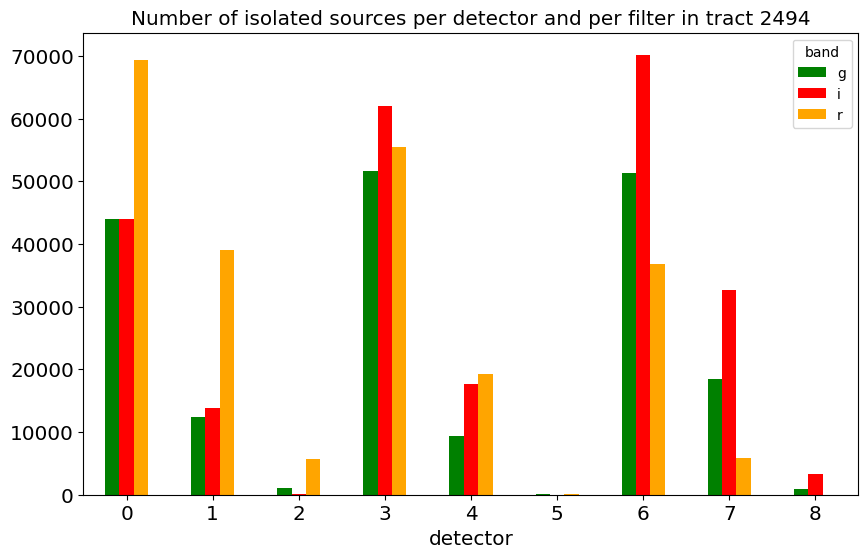

In [26]:
from itertools import cycle, islice
my_colors = list(islice(cycle(['g', 'r', 'orange']), None, len(df_isolatedstar_perdetectorband)))
df_isolatedstar_perdetectorband.plot.bar(color=my_colors,rot=0,title=f"Number of isolated sources per detector and per filter in tract {tract}") 

In [27]:
NDET=9
import seaborn as sns

In [28]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette("hls", NDET))
all_det_colors = [cmap.colors[idx] for idx in range(NDET)]

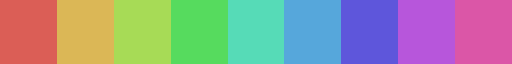

In [29]:
cmap

In [30]:
df_isolatedstar_perdetectorband = ser_isolatedstar_perdetectorband_size.unstack(level=0)
df_isolatedstar_perdetectorband 

detector,0,1,2,3,4,5,6,7,8
band,,,,,,,,,
g,44031.0,12420.0,1028.0,51688.0,9421.0,60.0,51383.0,18417.0,904.0
i,43982.0,13818.0,37.0,61921.0,17733.0,11.0,70175.0,32574.0,3310.0
r,69377.0,39064.0,5755.0,55460.0,19317.0,166.0,36782.0,5870.0,NaN


In [31]:
# not working 
#my_colors_cycle = list(islice(cycle(all_det_colors), None, len(df_isolatedstar_perdetectorband)))
#my_colors_cycle = list(islice(cycle(all_det_colors),None,3))

In [32]:
# not working
#import itertools
#my_colors_cycle = itertools.cycle(all_det_colors)
#my_colors_cycle = itertools.cycle(cmap)

<Axes: title={'center': 'Number of isolated sources per detector and per filter in tract 2494'}, xlabel='band'>

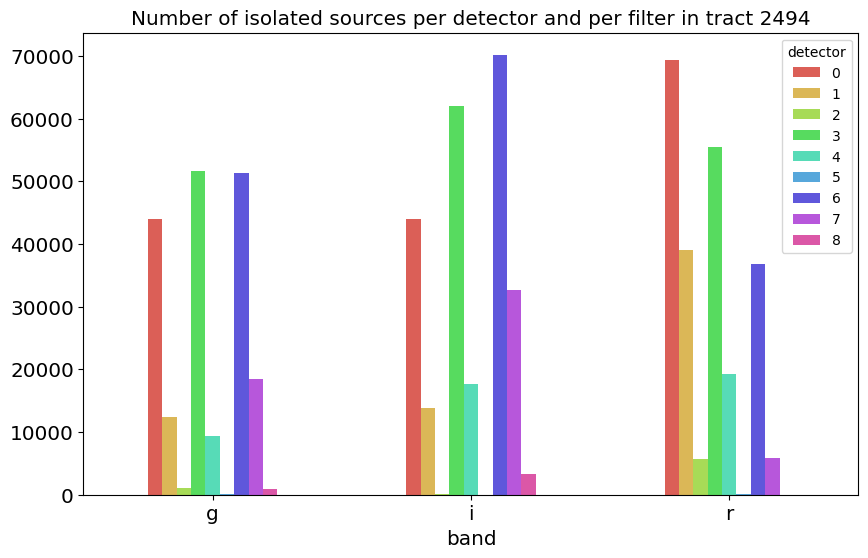

In [33]:
df_isolatedstar_perdetectorband.plot.bar(color=all_det_colors + all_det_colors + all_det_colors,rot=0,title=f"Number of isolated sources per detector and per filter in tract {tract}") 

<Axes: title={'center': 'Number of isolated sources per detector and per filter in tract 2494'}, xlabel='detector,band'>

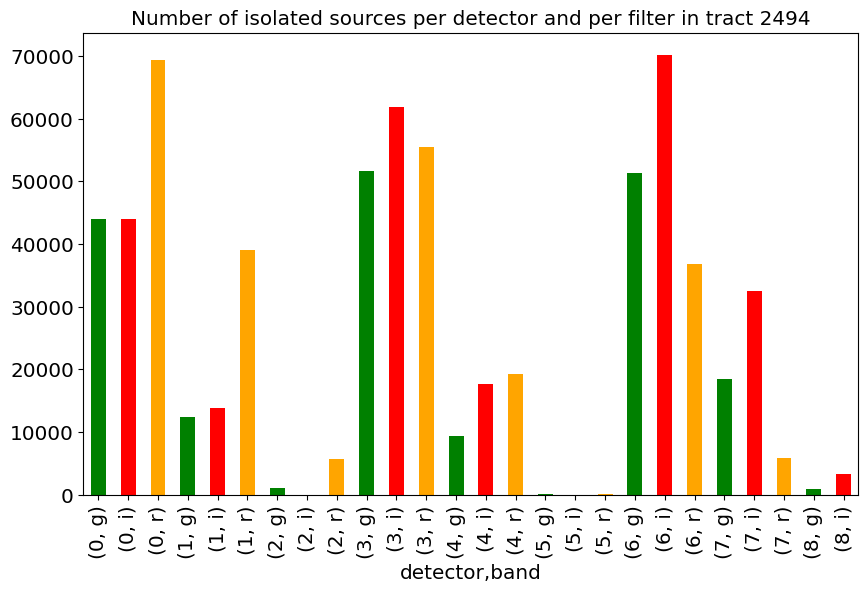

In [34]:
my_colors = list(islice(cycle(['g', 'r', 'orange']), None, NDET))
ser_isolatedstar_perdetectorband_size.plot.bar(x="detector",color=my_colors,title=f"Number of isolated sources per detector and per filter in tract {tract}")

## Select a number of visits with enough good sources but in all bands here

- extract the list of known objects

In [35]:
calibFluxStr

'apFlux_12_0_instFlux'

In [36]:
minSnCalibFlux

100

In [37]:
# Trim the isolated_star_sources cat to those PSF S/N > minSnCalibFlux
# and number of matches sources > minNumMatches.
objIndexListFull = list(set(isolatedStarSourcesFull["obj_index"].values))

# Select the bright stars above a minimum of S/N ratio
if minSnCalibFlux is not None:
    snCalibFlux = isolatedStarSourcesFull[calibFluxStr]/isolatedStarSourcesFull[calibFluxStr + "Err"]
    snMask = snCalibFlux > minSnCalibFlux
    isolatedStarSourcesMinSn = isolatedStarSourcesFull[snMask].copy(deep=True)
else:
    isolatedStarSourcesMinSn = isolatedStarSourcesFull.copy(deep=True)

# object index with obj index in above selected bright selected star
objIndexListMinSn = list(set(isolatedStarSourcesMinSn["obj_index"].values))

# requires that the object is associated to several sources (at least minNumMatches sources)
# loop on object having sources with S/N aboe selection 
objIndexList = []
for objIndex in objIndexListMinSn:
    objData = isolatedStarSourcesMinSn[isolatedStarSourcesMinSn["obj_index"] == objIndex]
    if len(objData) >= minNumMatches:
        objIndexList.append(objIndex)
numTrimmed = len(objIndexListFull) - len(objIndexList)

mask = []
for objIndex, visit in zip(isolatedStarSourcesMinSn["obj_index"], isolatedStarSourcesMinSn["visit"]):
    if objIndex in objIndexList:
        mask.append(True)
    else:
        mask.append(False)
isolatedStarSources = isolatedStarSourcesMinSn[mask].copy(deep=True)

# Select a number of visits according quality criteria
visitList = list(set(isolatedStarSources["visit"].values))

if minSnCalibFlux is not None:
    print("Trimmed isolated_star_sources catalog to S/N {} > {} (leaving N={} matched sources from original {})".format(
        calibFluxStr, minSnCalibFlux, len(isolatedStarSources), len(isolatedStarSourcesFull)))
print("Trimmed isolated_star_sources catalog to objecst with nMatches >= {} (leaving {} objects from {}).".format(
    minNumMatches, len(objIndexList), len(objIndexListFull)))

Trimmed isolated_star_sources catalog to S/N apFlux_12_0_instFlux > 100 (leaving N=231582 matched sources from original 664704)
Trimmed isolated_star_sources catalog to objecst with nMatches >= 3 (leaving 8308 objects from 28604).


In [38]:
sorted_visitList = sorted(visitList)
#sorted_visitList 

In [39]:
def convertVisitToDatestr(visit):

    num = visit//100_000
    year = num//10_000
    month= (num-year*10_000)//100
    day = (num-year*10_000-month*100)

    year_str = str(year).zfill(4)
    month_str = str(month).zfill(2)
    day_str = str(day).zfill(2)
    
    datestr = f"{year_str}-{month_str}-{day_str}"
    return datestr

In [40]:
def convertVisitToMJD(visit):
    return Time(convertVisitToDatestr(visit)).mjd

In [41]:
sorted_visits_mjd = list(map(convertVisitToMJD, sorted_visitList))

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


## sourceTable_visit

This is the main output of FGCM calibration which has selected a number of sources. These sources were originally selected from isolated sources.

In [42]:
# Extra columns to load from sourceTable_visit catalogs
names = ["psfFlux", "psfFluxErr", "psfFlux_flag", "psfFlux_apCorr", "psfFlux_apCorrErr",
         "extendedness", "detect_isPrimary", "deblend_skipped",
         "gaussianFlux", "gaussianFluxErr", "gaussianFlux_flag",
         "localPhotoCalib", "localPhotoCalibErr", "localPhotoCalib_flag"]

## Note that some sourceTable_visit not found for some visits in isolated_star_sources 

In [43]:
#visitList

Note here that the sourceId is the same in isolated_source_table and sourceTable

In [44]:
# Load in the sourceTable_visit catalogs to get the psfFlux and other useful info per source.
# Columns loaded are those in names above.
# The selected sources from the sourceTable_visit will go in a list inside the sourceCatalog

sourceCatalogs = []
nSourceDict = {}
visitsToRemove = []

# loop over all selected visit and load sourceTable_visit visit per visit
for visit in visitList:
    try:
        sourceCatalogOrig = butler.get("sourceTable_visit", visit=visit, parameters={"columns": names})
        #select all the sources that have a "detect_isPrimary" flag in the sourceTable_visit
        primaryCat = sourceCatalogOrig[sourceCatalogOrig["detect_isPrimary"]].copy(deep=True)
        # count the number of sources having S/N > 5 in this visit
        nSourceDict[visit] = sum(primaryCat["psfFlux"]/primaryCat["psfFluxErr"] > 5)
        #keep those sources hat have a "detect_isPrimary" flag in the sourceTable_visit in a list of list of sources per visits
        sourceCatalogs.append(primaryCat)
    except LookupError:
        print("sourceTable_visit not found for visit {} which was in isolated_star_sources".format(visit))
        isolatedStarSources = isolatedStarSources[isolatedStarSources["visit"] != visit].copy(deep=True)
        visitsToRemove.append(visit)
visitList = list(set(visitList) - set(visitsToRemove))

# Do the minNumMatches cut again since visits may have been removed due to lack of sourceTable_visit
print("Number of objects with >=3 matches before sourceTable_visit exsistence check: {}".format(len(objIndexList)))
objIndexListAllNew = list(set(isolatedStarSources["obj_index"].values))
objIndexList = []
for objIndex in objIndexListAllNew:
    objData = isolatedStarSources[isolatedStarSources["obj_index"] == objIndex]
    if len(objData) >= minNumMatches:
        objIndexList.append(objIndex)
mask = []
for objIndex, visit in zip(isolatedStarSources["obj_index"], isolatedStarSources["visit"]):
    if objIndex in objIndexList:
        mask.append(True)
    else:
        mask.append(False)
isolatedStarSources = isolatedStarSources[mask].copy(deep=True)
visitList = list(set(isolatedStarSources["visit"].values))
print("Number of objects with >=3 matches after sourceTable_visit existence check: {}".format(len(objIndexList)))

# Final action associate the source in the sourceTable if the visit to the source in the isolated_source_table 
# on source sourceid and then concat all merged 
dataJoined = pd.concat(sourceCatalogs).merge(isolatedStarSources, on="sourceId", how="inner")

sourceTable_visit not found for visit 7024040300584 which was in isolated_star_sources
sourceTable_visit not found for visit 7024040300680 which was in isolated_star_sources
sourceTable_visit not found for visit 7024040300690 which was in isolated_star_sources
sourceTable_visit not found for visit 7024040300692 which was in isolated_star_sources
sourceTable_visit not found for visit 7024040300694 which was in isolated_star_sources
sourceTable_visit not found for visit 7024040300699 which was in isolated_star_sources
sourceTable_visit not found for visit 7024040300700 which was in isolated_star_sources
sourceTable_visit not found for visit 7024040300720 which was in isolated_star_sources
Number of objects with >=3 matches before sourceTable_visit exsistence check: 8308
Number of objects with >=3 matches after sourceTable_visit existence check: 8215


In [45]:
len(sourceCatalogs)

101

In [46]:
#nSourceDict

In [47]:
#visitList

In [48]:
visitsToRemove 

[7024040300584,
 7024040300680,
 7024040300690,
 7024040300692,
 7024040300694,
 7024040300699,
 7024040300700,
 7024040300720]

## Will start to work on dataJoined which associate selected "isolated_star_sources" in the selected band and visits the good calibration in "sourceTable_visit"

### retrieve CCD Visit Table

- it provides airmass and initial zero-point

In [49]:
ccdVisitTable = butler.get("ccdVisitTable")

In [50]:
 ccdVisitTable

,visitId,physical_filter,band,ra,dec,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,decl,detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec
ccdVisitId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
730865860864,7024040300001,r_03,r,124.617999,-15.026212,17.825243,31.258871,1.507056,1703.767822,34.471790,0.005423,0.003085,534,0.000671,0.000063,0.010385,0.010232,-0.001001,0.009205,0.006108,0.012708,343.330109,11.789084,1.127149,0.344765,1.011240,-15.026212,0,0.711160,121.461718,2024-04-03 23:30:29.555496,60403.979509,30.0,2024-04-03 23:30:14.555496,60403.979335,33.0576,4071,3999,124.458471,-15.063877,124.581823,-14.871498,124.777487,-14.988434,124.654231,-15.180921
730865860865,7024040300001,r_03,r,124.745824,-14.826505,18.059967,31.238535,1.508598,1674.763306,32.659889,0.004810,0.002649,521,-0.000758,0.000405,0.010847,0.010906,-0.000540,0.010071,0.006677,0.011858,327.926941,11.528691,1.124846,0.350736,0.974059,-14.826505,1,0.710764,121.461718,2024-04-03 23:30:29.555496,60403.979509,30.0,2024-04-03 23:30:14.555496,60403.979335,33.0576,4071,3999,124.586453,-14.864268,124.709592,-14.671812,124.905148,-14.788632,124.782113,-14.981198
730865860866,7024040300001,r_03,r,124.873418,-14.626731,18.294695,31.259706,1.525470,1709.555664,33.396534,0.004649,0.002711,499,-0.000471,-0.000007,0.010723,0.010910,0.000434,0.009015,0.005919,0.015276,507.804199,11.484890,1.100101,0.343598,1.012796,-14.626731,2,0.718461,121.461718,2024-04-03 23:30:29.555496,60403.979509,30.0,2024-04-03 23:30:14.555496,60403.979335,33.0576,4071,3999,124.714213,-14.664580,124.837124,-14.472080,125.032570,-14.588777,124.909767,-14.781395
730865860867,7024040300001,r_03,r,124.824851,-15.149693,17.819584,31.267454,1.514115,1717.083984,34.223988,0.004732,0.002868,504,-0.000470,-0.000685,0.009737,0.010434,-0.000375,0.010328,0.006824,0.019305,371.574188,11.773538,1.116663,0.342092,1.027357,-15.149693,3,0.713278,121.461718,2024-04-03 23:30:29.555496,60403.979509,30.0,2024-04-03 23:30:14.555496,60403.979335,33.0576,4071,3999,124.665250,-15.187500,124.788499,-14.995008,124.984403,-15.111770,124.861257,-15.304366
730865860868,7024040300001,r_03,r,124.952564,-14.949870,18.054384,31.265049,1.510671,1714.527710,33.346077,0.004954,0.002795,472,0.000277,0.000023,0.009188,0.009661,0.000165,0.010904,0.007214,0.009335,364.833038,11.792562,1.121760,0.342602,1.022816,-14.949870,4,0.711782,121.461718,2024-04-03 23:30:29.555496,60403.979509,30.0,2024-04-03 23:30:14.555496,60403.979335,33.0576,4071,3999,124.793126,-14.987773,124.916155,-14.795198,125.111945,-14.911856,124.989026,-15.104533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730866060292,7024040300780,r_03,r,299.857944,-40.858541,19.874241,31.276102,1.663994,1544.489258,31.839106,0.006128,0.003535,742,0.000638,-0.000605,0.012558,0.010842,-0.000502,0.011414,0.006865,0.012346,238.200607,11.011467,0.924563,0.380320,1.043851,-40.858541,4,0.784160,133.834081,2024-04-04 10:27:54.199510,60404.436044,30.0,2024-04-04 10:27:39.199510,60404.435870,33.0575,4071,3999,299.648263,-40.863270,299.855183,-40.699906,300.067595,-40.853432,299.860717,-41.017175
730866060293,7024040300780,r_03,r,300.072069,-40.688646,19.948414,31.241217,1.658965,1498.435913,32.142555,0.006090,0.003350,783,-0.000532,0.000092,0.010783,0.010751,0.000342,0.010660,0.006418,0.008839,369.936768,10.708126,0.930177,0.392009,0.978883,-40.688646,5,0.781568,133.834081,2024-04-04 10:27:54.199510,60404.436044,30.0,2024-04-04 10:27:39.199

In [51]:
ccdVisitTable_subset = ccdVisitTable.iloc[:20][["visitId","detector","band"]]
ccdVisitTable_subset

,visitId,detector,band
ccdVisitId,,,
730865860864,7024040300001,0,r
730865860865,7024040300001,1,r
730865860866,7024040300001,2,r
730865860867,7024040300001,3,r
730865860868,7024040300001,4,r
730865860869,7024040300001,5,r
730865860870,7024040300001,6,r
730865860871,7024040300001,7,r
730865860872,7024040300001,8,r


In [52]:
#ccdVisitTable_noindex = ccdVisitTable.reset_index()
#ccdVisitTable_noindex
#ccdVisitTable_noindex.groupby(["ccdVisitId","detector"]).size()

In [53]:
ccdVisitTable.groupby(["visitId","ccdVisitId","detector"]).size()

visitId        ccdVisitId    detector
7024040300001  730865860864  0           1
               730865860865  1           1
               730865860866  2           1
               730865860867  3           1
               730865860868  4           1
                                        ..
7024040300780  730866060292  4           1
               730866060293  5           1
               730866060294  6           1
               730866060295  7           1
               730866060296  8           1
Length: 6301, dtype: int64

Thus one ccvisit is associated to one visit id and a detector id
wheras the visitId has

In [54]:
for visit in visitList:
    if visit in ccdVisitTable["visitId"].values:
        print(ccdVisitTable[ccdVisitTable["visitId"] == visit]["zeroPoint"])
        print(ccdVisitTable[ccdVisitTable["visitId"] == visit]["detector"])
        break

ccdVisitId
730865999872    31.247652
730865999873    31.226870
730865999874    31.247919
730865999875    31.255438
730865999876    31.252151
730865999877    31.216717
730865999878    31.252094
730865999879    31.236282
730865999880    31.226637
Name: zeroPoint, dtype: float32
ccdVisitId
730865999872    0
730865999873    1
730865999874    2
730865999875    3
730865999876    4
730865999877    5
730865999878    6
730865999879    7
730865999880    8
Name: detector, dtype: int64


### Calculate Airmass and Ellipticity

In [55]:
ccdVisitTable["airmass"] = ccdVisitTable["zenithDistance"].apply(lambda x: 1/np.cos(np.pi/180.*x))
ccdVisitTable["medianE"] = np.sqrt(ccdVisitTable["psfStarDeltaE1Median"] ** 2.0 + ccdVisitTable["psfStarDeltaE2Median"] ** 2.0)

In [56]:
# Collect useful columns from ccdVisitTable
# This is wrong when we have several detectors per visit
if 0:
    visitsCCDToRemove = []

    #Note there is one value per detector
    psfSigmaDict = {}
    skyBgDict = {}
    skyNoiseDict = {}
    expTimeDict = {}
    expMidptMjdDict = {}
    medianEDict = {}
    psfStarScaledDeltaSizeScatterDict = {}
    astromOffsetStdDict = {}
    psfTraceRadiusDeltaDict = {}
    zeroPointDict = {}
    airmassDict = {}
    seeingDict = {}

    for visit in visitList:
        if visit in ccdVisitTable["visitId"].values:
            psfSigmaDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["psfSigma"].values[0]
            skyBgDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["skyBg"].values[0]
            skyNoiseDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["skyNoise"].values[0]
            expTimeDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["expTime"].values[0]
            expMidptMjdDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["expMidptMJD"].values[0]
            medianEDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["medianE"].values[0]
            psfStarScaledDeltaSizeScatterDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["psfStarScaledDeltaSizeScatter"].values[0]
            astromOffsetStdDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["astromOffsetStd"].values[0]
            psfTraceRadiusDeltaDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["psfTraceRadiusDelta"].values[0]
            zeroPointDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["zeroPoint"].values[0]
            airmassDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["airmass"].values[0]
            seeingDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["seeing"].values[0]

        else:
            #raise RuntimeError("ERROR: visit {} not found in ccdVisitTable".format(visit))
            print("ERROR: CCD visit {} not found in ccdVisitTable".format(visit))
            visitsCCDToRemove.append(visit) 
            psfSigmaDict[visit] = np.nan
            skyBgDict[visit] = np.nan
            skyNoiseDict[visit] = np.nan
            expTimeDict[visit] = np.nan
            expMidptMjdDict[visit] = np.nan
            medianEDict[visit] = np.nan
            psfStarScaledDeltaSizeScatterDict[visit] = np.nan
            astromOffsetStdDict[visit] = np.nan
            psfTraceRadiusDeltaDict[visit] = np.nan
            zeroPointDict[visit] = np.nan
            airmassDict[visit] = np.nan
            seeingDict[visit] = np.nan

In [57]:
#visitList

In [58]:
#visitsToRemove 

In [59]:
#visitsCCDToRemove

In [60]:
# Just to have a look at what's in the catalog:
#ccdVisitTable[ccdVisitTable.index == ccdVisitTable.index[:5]] 

### Plot visits versus time

In [61]:
ccdVisitTable_subset = ccdVisitTable[["visitId","band","zeroPoint","psfSigma","skyBg","skyNoise","seeing","expTime","expMidptMJD","obsStart","airmass","medianE","psfStarScaledDeltaSizeScatter",
                                      "astromOffsetStd","psfTraceRadiusDelta",
                                      "llcra","llcdec","ulcra","ulcdec","urcra","urcdec","lrcra","lrcdec"]]

#### compute nightObs and datetime time

In [62]:
ccdVisitTable_subset["nightObs"] = ccdVisitTable_subset.apply(lambda x: x['visitId']//100_000 - 50000000, axis=1)
ccdVisitTable_subset["Time"] = pd.to_datetime(ccdVisitTable_subset['obsStart'])

/tmp/ipykernel_16468/257659302.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ccdVisitTable_subset["nightObs"] = ccdVisitTable_subset.apply(lambda x: x['visitId']//100_000 - 50000000, axis=1)
/tmp/ipykernel_16468/257659302.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ccdVisitTable_subset["Time"] = pd.to_datetime(ccdVisitTable_subset['obsStart'])


In [63]:
ccdVisitTable_g = ccdVisitTable_subset[ccdVisitTable_subset.band== "g"]
ccdVisitTable_r = ccdVisitTable_subset[ccdVisitTable_subset.band== "r"]
ccdVisitTable_i = ccdVisitTable_subset[ccdVisitTable_subset.band== "i"]
#ccdVisitTable_z = ccdVisitTable_subset[ccdVisitTable_subset.band== "z"]
#ccdVisitTable_y = ccdVisitTable_subset[ccdVisitTable_subset.band== "y"]

In [64]:
ccdVisitTable_subset.head()

,visitId,band,zeroPoint,psfSigma,skyBg,skyNoise,seeing,expTime,expMidptMJD,obsStart,airmass,medianE,psfStarScaledDeltaSizeScatter,astromOffsetStd,psfTraceRadiusDelta,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,nightObs,Time
ccdVisitId,,,,,,,,,,,,,,,,,,,,,,,,,
730865860864,7024040300001,r,31.258871,1.507056,1703.767822,34.471790,0.711160,30.0,60403.979509,2024-04-03 23:30:14.555496,1.050426,0.000674,0.006108,0.003085,0.012708,124.458471,-15.063877,124.581823,-14.871498,124.777487,-14.988434,124.654231,-15.180921,20240403,2024-04-03 23:30:14.555496
730865860865,7024040300001,r,31.238535,1.508598,1674.763306,32.659889,0.710764,30.0,60403.979509,2024-04-03 23:30:14.555496,1.051820,0.000859,0.006677,0.002649,0.011858,124.586453,-14.864268,124.709592,-14.671812,124.905148,-14.788632,124.782113,-14.981198,20240403,2024-04-03 23:30:14.555496
730865860866,7024040300001,r,31.259706,1.525470,1709.555664,33.396534,0.718461,30.0,60403.979509,2024-04-03 23:30:14.555496,1.053236,0.000471,0.005919,0.002711,0.015276,124.714213,-14.664580,124.837124,-14.472080,125.032570,-14.588777,124.909767,-14.781395,20240403,2024-04-03 23:30:14.555496
730865860867,7024040300001,r,31.267454,1.514115,1717.083984,34.223988,0.713278,30.0,60403.979509,2024-04-03 23:30:14.555496,1.050393,0.000830,0.006824,0.002868,0.019305,124.665250,-15.187500,124.788499,-14.995008,124.984403,-15.111770,124.861257,-15.304366,20240403,2024-04-03 23:30:14.555496
730865860868,7024040300001,r,31.265049,1.510671,1714.527710,33.346077,0.711782,30.0,60403.979509,2024-04-03 23:30:14.555496,1.051787,0.000278,0.007214,0.002795,0.009335,124.793126,-14.987773,124.916155,-14.795198,125.111945,-14.911856,124.989026,-15.104533,20240403,2024-04-03 23:30:14.555496


In [65]:
ccdVisitTable_subset["removed"] = ccdVisitTable_subset["visitId"].apply(lambda x: True if x in visitsToRemove else False) 

/tmp/ipykernel_16468/2046120826.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ccdVisitTable_subset["removed"] = ccdVisitTable_subset["visitId"].apply(lambda x: True if x in visitsToRemove else False)


In [66]:
ccdVisitTable_subset_removed = ccdVisitTable_subset[ccdVisitTable_subset["removed"]] 

In [67]:
ccdVisitTable_subset_removed 

,visitId,band,zeroPoint,psfSigma,skyBg,skyNoise,seeing,expTime,expMidptMJD,obsStart,airmass,medianE,psfStarScaledDeltaSizeScatter,astromOffsetStd,psfTraceRadiusDelta,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,nightObs,Time,removed
ccdVisitId,,,,,,,,,,,,,,,,,,,,,,,,,,


#### Thus the visit IN isolated-star_sources and MISSING in sourceTable are also NOT in ccdVisitTable !!!

In [68]:
ccdVisitTable_subset.tail()

,visitId,band,zeroPoint,psfSigma,skyBg,skyNoise,seeing,expTime,expMidptMJD,obsStart,airmass,medianE,psfStarScaledDeltaSizeScatter,astromOffsetStd,psfTraceRadiusDelta,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,nightObs,Time,removed
ccdVisitId,,,,,,,,,,,,,,,,,,,,,,,,,,
730866060292,7024040300780,r,31.276102,1.663994,1544.489258,31.839106,0.784160,30.0,60404.436044,2024-04-04 10:27:39.199510,1.063331,0.000879,0.006865,0.003535,0.012346,299.648263,-40.863270,299.855183,-40.699906,300.067595,-40.853432,299.860717,-41.017175,20240403,2024-04-04 10:27:39.199510,False
730866060293,7024040300780,r,31.241217,1.658965,1498.435913,32.142555,0.781568,30.0,60404.436044,2024-04-04 10:27:39.199510,1.063830,0.000540,0.006418,0.003350,0.008839,299.862940,-40.693761,300.068800,-40.530029,300.281152,-40.683155,300.075350,-40.847272,20240403,2024-04-04 10:27:39.199510,False
730866060294,7024040300780,r,31.276382,1.663328,1540.607056,32.586014,0.782899,30.0,60404.436044,2024-04-04 10:27:39.199510,1.064358,0.000249,0.006938,0.003625,0.012688,299.656968,-41.195332,299.864904,-41.031966,300.078406,-41.185459,299.870518,-41.349193,20240403,2024-04-04 10:27:39.199510,False
730866060295,7024040300780,r,31.260756,1.658629,1523.149414,31.984844,0.781810,30.0,60404.436044,2024-04-04 10:27:39.199510,1.064839,0.000879,0.006753,0.003758,0.015594,299.872697,-41.025821,300.079575,-40.862055,300.293012,-41.015162,300.086197,-41.179299,20240403,2024-04-04 10:27:39.199510,False
730866060296,7024040300780,r,31.251465,1.658580,1514.597778,32.967434,0.780872,30.0,60404.436044,2024-04-04 10:27:39.199510,1.065340,0.000416,0.006158,0.003323,0.009968,300.087328,-40.855895,300.293126,-40.691757,300.506492,-40.844470,300.300763,-41.008987,20240403,2024-04-04 10:27:39.199510,False


In [69]:
# function of time conversion
from astropy.time import Time

def dt_to_mjd(dt):
    t = Time(dt)
    return t.to_value('mjd','float')

def mjd_to_dt(mjd):
    tm = Time(mjd, format='mjd')
    # Convert to datetime
    utc =tm.to_datetime()
    return utc

In [70]:
dt = ccdVisitTable_subset.iloc[0]['Time']
dt

Timestamp('2024-04-03 23:30:14.555496')

In [71]:
type(dt)

pandas._libs.tslibs.timestamps.Timestamp

In [72]:
mjd = dt_to_mjd(dt)
mjd

60403.97933513306

In [73]:
tm = mjd_to_dt(mjd)

In [74]:
#ax.secondary_xaxis?

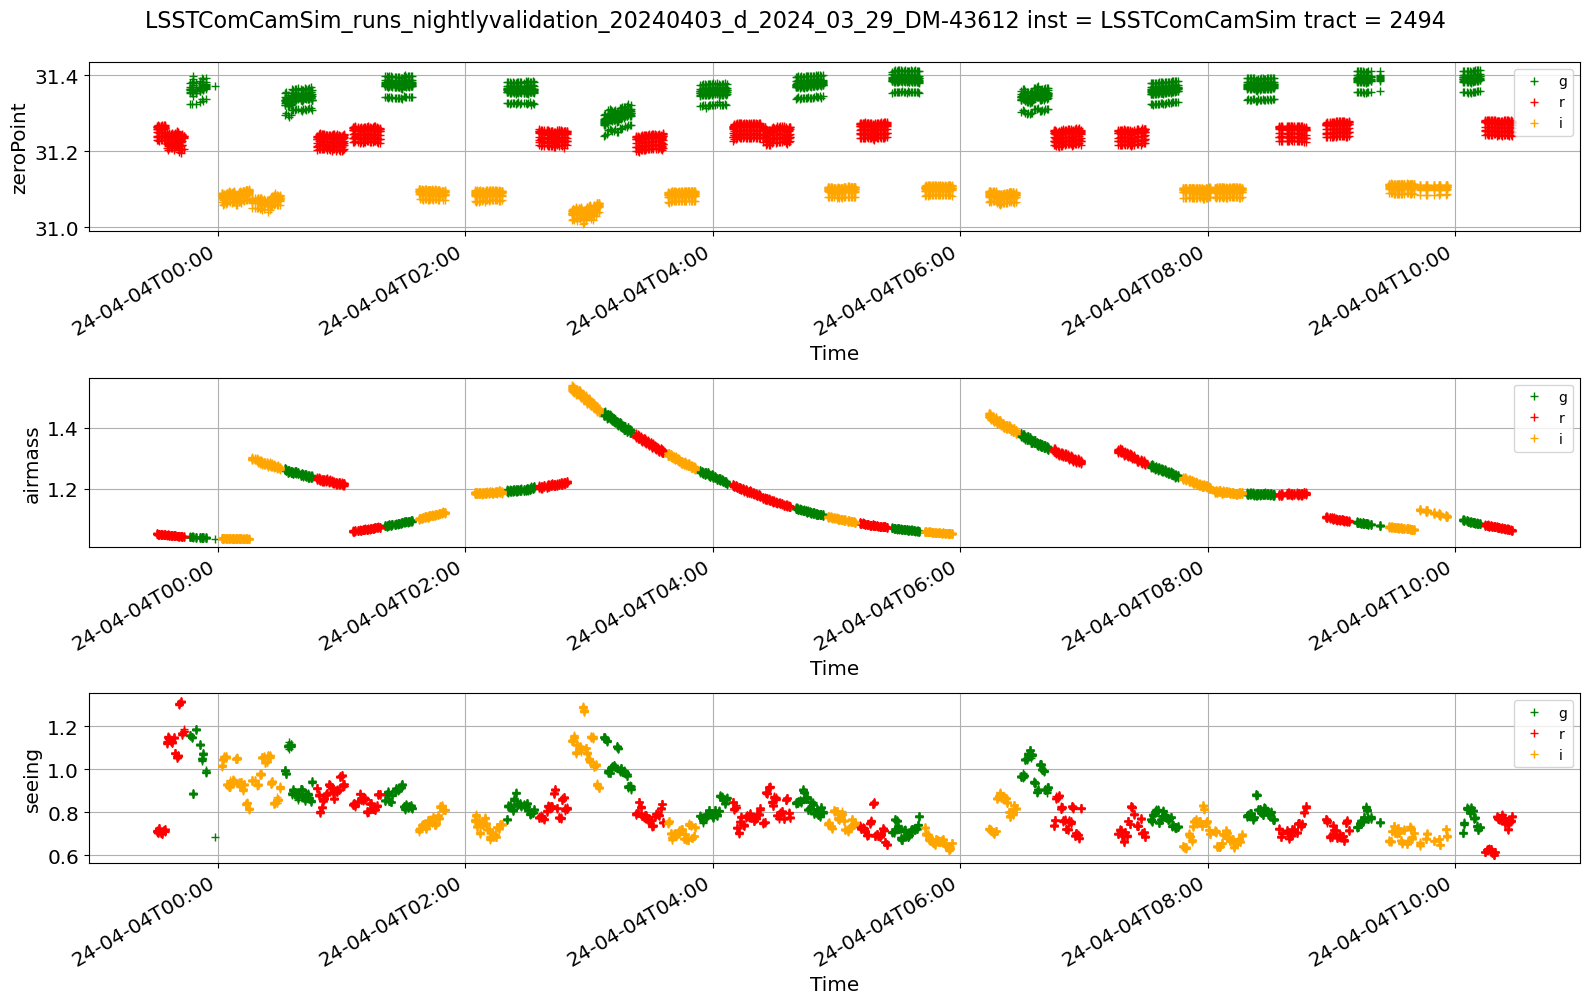

In [75]:
from matplotlib.dates import DateFormatter
date_form = DateFormatter("%y-%m-%dT%H:%M")

fig,axs = plt.subplots(3,1,figsize=(16,10))
ax1,ax2,ax3 = axs
ccdVisitTable_g.plot(x="Time",y="zeroPoint",marker='+',c="g",lw=0.0,ax=ax1,grid=True,label="g")
ccdVisitTable_r.plot(x="Time",y="zeroPoint",marker='+',c="r",lw=0.0,ax=ax1,grid=True,label="r")
ccdVisitTable_i.plot(x="Time",y="zeroPoint",marker='+',c="orange",lw=0.0,ax=ax1,grid=True,label="i")
#ccdVisitTable_z.plot(x="Time",y="zeroPoint",marker='+',c="grey",lw=0.0,ax=ax1,grid=True,label="z")
#ccdVisitTable_g.plot(x="Time",y="zeroPoint",marker='+',c="k",lw=0.0,ax=ax1,grid=True,label="y")
#ax1.set_title("zeroPoint")
ax1.set_ylabel("zeroPoint")
ax1.xaxis.set_major_formatter(date_form)
#ax1_up = ax1.secondary_xaxis("top", functions=( dt_to_mjd, mjd_to_dt))
#ccdVisitTable_g.plot(x="expMidptMJD",y="zeroPoint",marker='+',c="g",lw=0.0,ax=ax1_up,grid=True,label="g")


ccdVisitTable_g.plot(x="Time",y="airmass",marker='+',c="g",lw=0.0,ax=ax2,grid=True,label="g")
ccdVisitTable_r.plot(x="Time",y="airmass",marker='+',c="r",lw=0.0,ax=ax2,grid=True,label="r")
ccdVisitTable_i.plot(x="Time",y="airmass",marker='+',c="orange",lw=0.0,ax=ax2,grid=True,label="i")
#ccdVisitTable_z.plot(x="Time",y="airmass",marker='+',c="grey",lw=0.0,ax=ax2,grid=True,label="z")
#ccdVisitTable_y.plot(x="Time",y="airmass",marker='+',c="k",lw=0.0,ax=ax2,grid=True,label="y")
#ax2.set_title("airmass")
ax2.set_ylabel("airmass")
ax2.xaxis.set_major_formatter(date_form)

ccdVisitTable_g.plot(x="Time",y="seeing",marker='+',c="g",lw=0.0,ax=ax3,grid=True,label="g")
ccdVisitTable_r.plot(x="Time",y="seeing",marker='+',c="r",lw=0.0,ax=ax3,grid=True,label="r")
ccdVisitTable_i.plot(x="Time",y="seeing",marker='+',c="orange",lw=0.0,ax=ax3,grid=True,label="i")
#ccdVisitTable_z.plot(x="Time",y="seeing",marker='+',c="grey",lw=0.0,ax=ax3,grid=True,label="z")
#ccdVisitTable_y.plot(x="Time",y="seeing",marker='+',c="k",lw=0.0,ax=ax3,grid=True,label="y")
#ax2.set_title("airmass")
ax3.set_ylabel("seeing")
ax3.xaxis.set_major_formatter(date_form)

#df.plot(x="Time",y="coord_dec",marker='o',c="g",lw=0.0,ax=ax2,grid=True)
plt.suptitle(suptitle,y=1.0,fontsize=16)
plt.tight_layout()



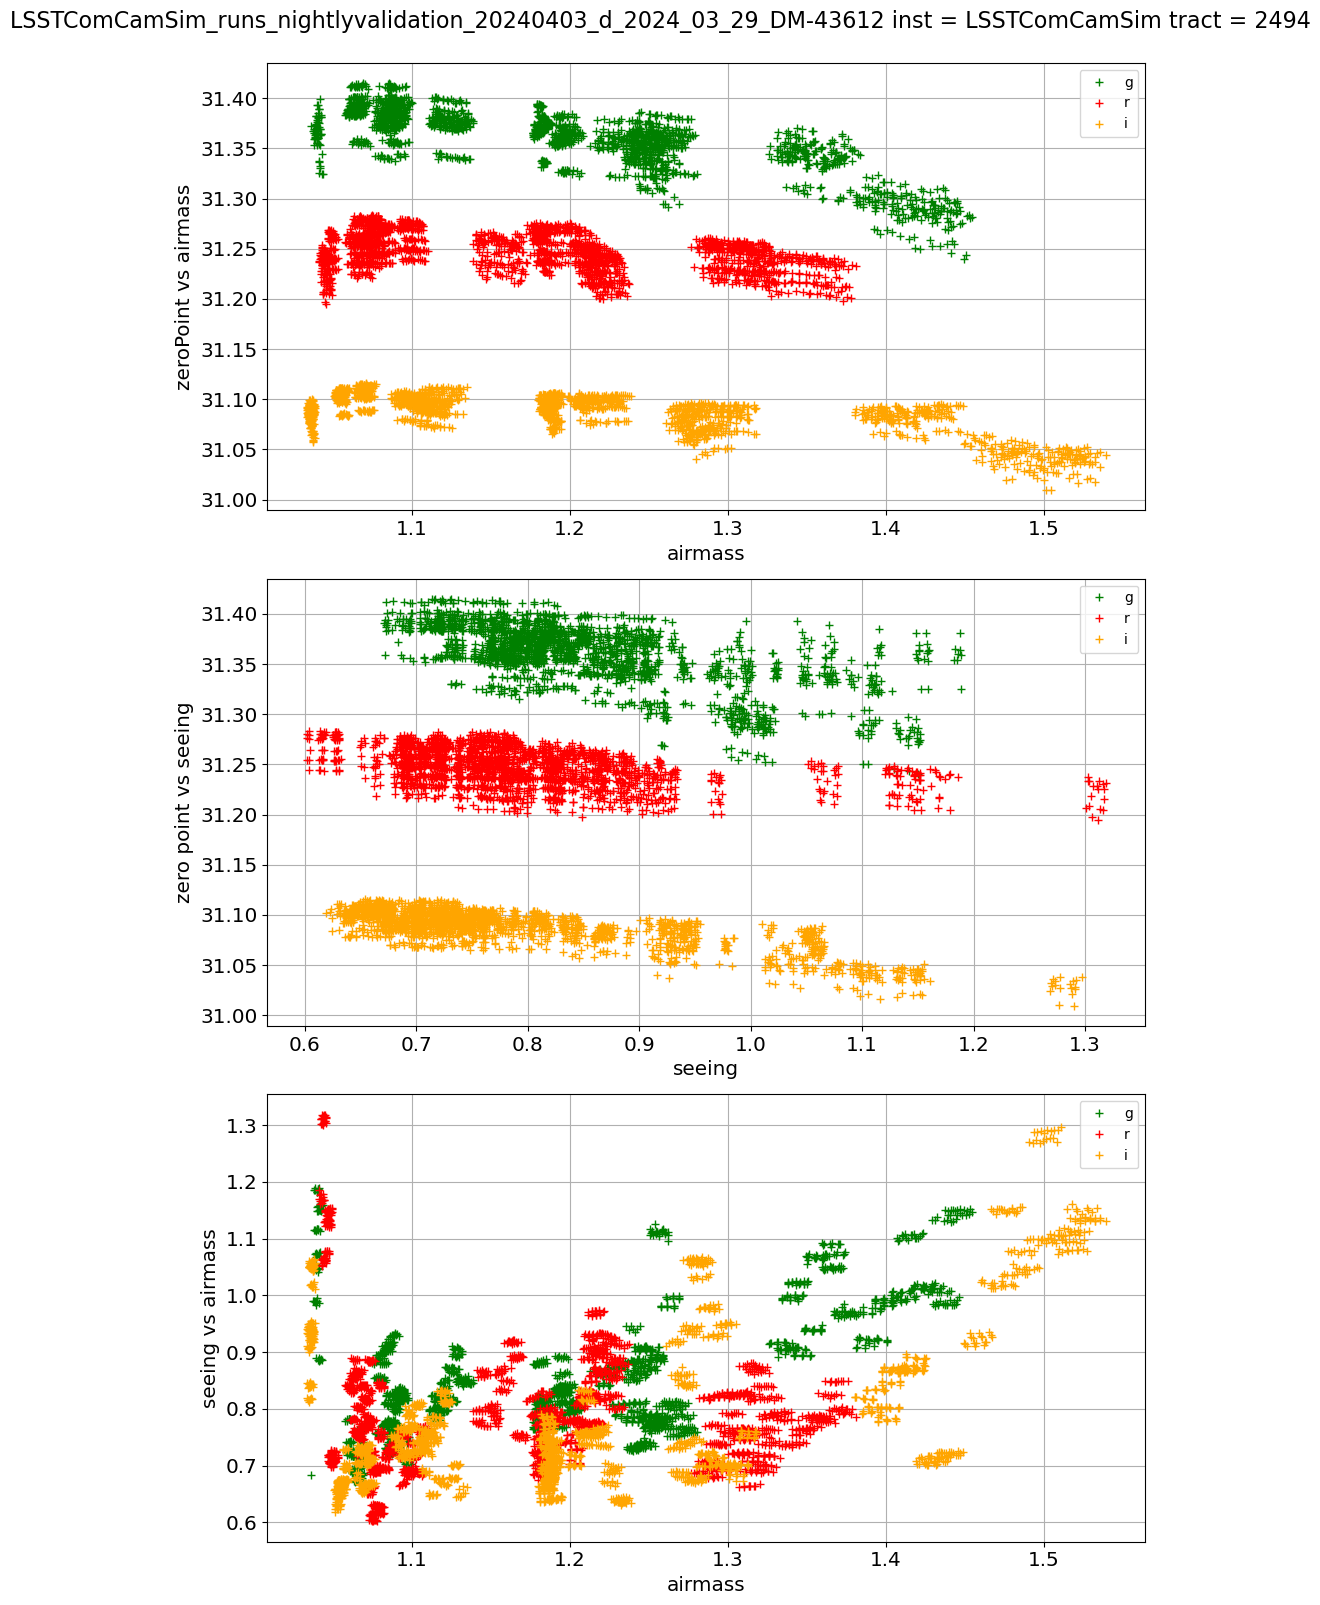

In [76]:
fig,axs = plt.subplots(3,1,figsize=(10,16))
ax1,ax2,ax3 = axs
ccdVisitTable_g.plot(x="airmass",y="zeroPoint",marker='+',c="g",lw=0.0,ax=ax1,grid=True,label="g")
ccdVisitTable_r.plot(x="airmass",y="zeroPoint",marker='+',c="r",lw=0.0,ax=ax1,grid=True,label="r")
ccdVisitTable_i.plot(x="airmass",y="zeroPoint",marker='+',c="orange",lw=0.0,ax=ax1,grid=True,label="i")
#ccdVisitTable_z.plot(x="airmass",y="zeroPoint",marker='+',c="grey",lw=0.0,ax=ax1,grid=True,label="z")
#ccdVisitTable_y.plot(x="airmass",y="zeroPoint",marker='+',c="k",lw=0.0,ax=ax1,grid=True,label="y")
#ax1.set_title("zeroPoint")
ax1.set_ylabel("zeroPoint vs airmass")
#ax1_up = ax1.secondary_xaxis("top", functions=( dt_to_mjd, mjd_to_dt))
#ccdVisitTable_g.plot(x="expMidptMJD",y="zeroPoint",marker='+',c="g",lw=0.0,ax=ax1_up,grid=True,label="g")

ccdVisitTable_g.plot(x="seeing",y="zeroPoint",marker='+',c="g",lw=0.0,ax=ax2,grid=True,label="g")
ccdVisitTable_r.plot(x="seeing",y="zeroPoint",marker='+',c="r",lw=0.0,ax=ax2,grid=True,label="r")
ccdVisitTable_i.plot(x="seeing",y="zeroPoint",marker='+',c="orange",lw=0.0,ax=ax2,grid=True,label="i")
#ccdVisitTable_z.plot(x="seeing",y="zeroPoint",marker='+',c="grey",lw=0.0,ax=ax2,grid=True,label="z")
#ccdVisitTable_y.plot(x="seeing",y="zeroPoint",marker='+',c="k",lw=0.0,ax=ax2,grid=True,label="y")
#ax2.set_title("airmass")
ax2.set_ylabel("zero point vs seeing")

ccdVisitTable_g.plot(x="airmass",y="seeing",marker='+',c="g",lw=0.0,ax=ax3,grid=True,label="g")
ccdVisitTable_r.plot(x="airmass",y="seeing",marker='+',c="r",lw=0.0,ax=ax3,grid=True,label="r")
ccdVisitTable_i.plot(x="airmass",y="seeing",marker='+',c="orange",lw=0.0,ax=ax3,grid=True,label="i")
#ccdVisitTable_z.plot(x="airmass",y="seeing",marker='+',c="grey",lw=0.0,ax=ax3,grid=True,label="z")
#ccdVisitTable_y.plot(x="airmass",y="seeing",marker='+',c="k",lw=0.0,ax=ax3,grid=True,label="y")
#ax2.set_title("airmass")
ax3.set_ylabel("seeing vs airmass")

#df.plot(x="Time",y="coord_dec",marker='o',c="g",lw=0.0,ax=ax2,grid=True)
plt.suptitle(suptitle,y=1.0,fontsize=16)
plt.tight_layout()

## Come-back to dataJoined

In [77]:
dataJoined.columns

Index(['sourceId', 'psfFlux', 'psfFluxErr', 'psfFlux_flag', 'psfFlux_apCorr',
       'psfFlux_apCorrErr', 'extendedness', 'detect_isPrimary',
       'deblend_skipped', 'gaussianFlux', 'gaussianFluxErr',
       'gaussianFlux_flag', 'localPhotoCalib', 'localPhotoCalibErr',
       'localPhotoCalib_flag', 'index', 'visit', 'detector', 'ra', 'dec',
       'physical_filter', 'band', 'apFlux_12_0_instFlux',
       'apFlux_12_0_instFluxErr', 'x', 'y', 'xErr', 'yErr',
       'apFlux_17_0_instFlux', 'apFlux_17_0_instFluxErr', 'apFlux_17_0_flag',
       'localBackground_instFlux', 'localBackground_flag', 'ixx', 'iyy', 'ixy',
       'source_row', 'obj_index'],
      dtype='object')

### recalculate sources properties inside dataJoined before adding CCDVisit info

In [78]:
# Add columns into dataJoined table to have them all in one place
dataJoined["psfSn"] = dataJoined["psfFlux"]/dataJoined["psfFluxErr"]
dataJoined["psfMag"] = (dataJoined["psfFlux"].values*u.nJy).to(u.ABmag).value
dataJoined["psfMagErr"] = 2.5/np.log(10.0)*(dataJoined["psfFluxErr"].values/dataJoined["psfFlux"].values)

#dataJoined["apFlux_35_0_calFlux"] = dataJoined["apFlux_35_0_instFlux"]*dataJoined["localPhotoCalib"]
#dataJoined["apFlux_35_0_calFluxErr"] = dataJoined["apFlux_35_0_instFluxErr"]*dataJoined["localPhotoCalib"]
# This is the way to apply aperture corrections :
dataJoined[calibFluxCalStr] = dataJoined[calibFluxStr]*dataJoined["localPhotoCalib"]
dataJoined[calibFluxCalErrStr] = dataJoined[calibFluxErrStr]*dataJoined["localPhotoCalib"]

#dataJoined[calibFluxStr] = (dataJoined[calibFluxStr].values*u.nJy).to(u.ABmag).value
#dataJoined[calibFluxStr] = 2.5/np.log(10.0)*(dataJoined[calibFluxStr].values/dataJoined[calibFluxStr].values)
dataJoined[calibFluxCalMagStr] = (dataJoined[calibFluxCalStr].values*u.nJy).to(u.ABmag).value
dataJoined[calibFluxCalMagErrStr] = 2.5/np.log(10.0)*(dataJoined[calibFluxCalErrStr].values/dataJoined[calibFluxCalStr].values)

# NOTE: psfFlux is the fgcm calibrated flux.  I'm pretty sure you get the "instrumental" 
# flux by dividing psfFlux by the localPhotoCalib value.
dataJoined["psfInstMag"] = ((dataJoined["psfFlux"].values/dataJoined["localPhotoCalib"].values)*u.nJy).to(u.ABmag).value
dataJoined["psfGausFluxRatio"] = dataJoined["psfFlux"]/dataJoined["gaussianFlux"]

### Extract info from CCDVisit

In [79]:
# Example of apply function format  that does what we expect
# dataJoined[["ra","dec"]].apply(lambda x: pd.Series([x["ra"], x["dec"]], index=['ra_2', 'dec_2']), axis=1)

In [80]:
# Example of function calculating in which detector is the source
def findCCDVisitPerSource(x):
    """
    Find the CCD visit cooresponding to that source
    """
    visitId = x["visit"]
    ra0 = x["ra"]
    dec0 = x ["dec"]
    ccd_visit_table_forthatvisit = ccdVisitTable[ccdVisitTable.visitId == visitId]
    ccd_visit_table_forthatvisit["select"] =  ccd_visit_table_forthatvisit.apply(lambda x :  is_in_polygon(ra0,dec0,(x["llcra"],x["llcdec"]), (x["lrcra"],x["lrcdec"]), (x["urcra"],x["urcdec"]),(x["ulcra"],x["ulcdec"])),axis=1)
    ccd_visit_table_forthatvisit = ccd_visit_table_forthatvisit[ccd_visit_table_forthatvisit["select"]] 
    ccd_visit_table_forthatvisit["dra"] = ra0 - ccd_visit_table_forthatvisit["ra"] 
    ccd_visit_table_forthatvisit["ddec"] = dec0 - ccd_visit_table_forthatvisit["dec"] 
    ccd_visit_table_forthatvisit.reset_index(inplace=True)
    ccd_visit_table_forthatvisit.rename(columns = {'ccdVisitId':'ccd_ccdVisitId',"visitId": "ccd_visitId","band":"ccd_band","detector":"ccd_detector"}, inplace = True) 
    ccd_visit_table_forthatvisit.drop(columns = ["physical_filter","ra","dec","select"],inplace=True)
    
    assert len(ccd_visit_table_forthatvisit == 1)
    # Convert the dataframe into a pandas series
    # Do not do ccd_visit_table_forthatvisit.T
    ser =  ccd_visit_table_forthatvisit.iloc[0,:]
    ser.name = "ccd_visit_table_forthatvisit"
    return ser
    

In [81]:
dataJoined_subset = dataJoined.iloc[:10]
dataJoined_subset_toadd = dataJoined_subset.apply(findCCDVisitPerSource,axis=1)
dataJoined_subset_toadd

,ccd_ccdVisitId,ccd_visitId,ccd_band,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,decl,ccd_detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,airmass,medianE,dra,ddec
0,730865999872,7024040300544,r,40.529137,31.247652,1.469387,805.57782,26.311092,0.004505,0.002748,1706,0.000118,0.000035,0.011436,0.011227,-0.000496,0.009868,0.006708,0.010058,193.601685,25.691765,1.185681,0.729166,0.990555,-47.896521,0,0.69262,141.735855,2024-04-04 07:18:52.089492,60404.30477,30.0,2024-04-04 07:18:37.089492,60404.304596,33.0565,4071,3999,279.541915,-47.878287,279.807847,-47.739247,280.012109,-47.914275,279.745803,-48.053787,1.315659,0.000123,-0.158274,0.054691
1,730865999872,7024040300544,r,40.529137,31.247652,1.469387,805.57782,26.311092,0.004505,0.002748,1706,0.000118,0.000035,0.011436,0.011227,-0.000496,0.009868,0.006708,0.010058,193.601685,25.691765,1.185681,0.729166,0.990555,-47.896521,0,0.69262,141.735855,2024-04-04 07:18:52.089492,60404.30477,30.0,2024-04-04 07:18:37.089492,60404.304596,33.0565,4071,3999,279.541915,-47.878287,279.807847,-47.739247,280.012109,-47.914275,279.745803,-48.053787,1.315659,0.000123,-0.205676,0.028687
2,730865999872,7024040300544,r,40.529137,31.247652,1.469387,805.57782,26.311092,0.004505,0.002748,1706,0.000118,0.000035,0.011436,0.011227,-0.000496,0.009868,0.006708,0.010058,193.601685,25.691765,1.185681,0.729166,0.990555,-47.896521,0,0.69262,141.735855,2024-04-04 07:18:52.089492,60404.30477,30.0,2024-04-04 07:18:37.089492,60404.304596,33.0565,4071,3999,279.541915,-47.878287,279.807847,-47.739247,280.012109,-47.914275,279.745803,-48.053787,1.315659,0.000123,-0.075467,0.096367
3,730865999872,7024040300544,r,40.529137,31.247652,1.469387,805.57782,26.311092,0.004505,0.002748,1706,0.000118,0.000035,0.011436,0.011227,-0.000496,0.009868,0.006708,0.010058,193.601685,25.691765,1.185681,0.729166,0.990555,-47.896521,0,0.69262,141.735855,2024-04-04 07:18:52.089492,60404.30477,30.0,2024-04-04 07:18:37.089492,60404.304596,33.0565,4071,3999,279.541915,-47.878287,279.807847,-47.739247,280.012109,-47.914275,279.745803,-48.053787,1.315659,0.000123,-0.101472,0.081095
4,730865999872,7024040300544,r,40.529137,31.247652,1.469387,805.57782,26.311092,0.004505,0.002748,1706,0.000118,0.000035,0.011436,0.011227,-0.000496,0.009868,0.006708,0.010058,193.601685,25.691765,1.185681,0.729166,0.990555,-47.896521,0,0.69262,141.735855,2024-04-04 07:18:52.089492,60404.30477,30.0,2024-04-04 07:18:37.089492,60404.304596,33.0565,4071,3999,279.541915,-47.878287,279.807847,-47.739247,280.012109,-47.914275,279.745803,-48.053787,1.315659,0.000123,-0.138840,0.061304
5,730865999872,7024040300544,r,40.529137,31.247652,1.469387,805.57782,26.311092,0.004505,0.002748,1706,0.000118,0.000035,0.011436,0.011227,-0.000496,0.009868,0.006708,0.010058,193.601685,25.691765,1.185681,0.729166,0.990555,-47.896521,0,0.69262,141.735855,2024-04-04 07:18:52.089492,60404.30477,30.0,2024-04-04 07:18:37.089492,60404.304596,33.0565,4071,3999,279.541915,-47.878287,279.807847,-47.739247,280.012109,-47.914275,279.745803,-48.053787,1.315659,0.000123,0.025844,0.147372
6,730865999872,7024040300544,r,40.529137,31.247652,1.469387,805.57782,26.311092,0.004505,0.002748,1706,0.000118,0.000035,0.011436,0.011227,-0.000496,0.009868,0.006708,0.010058,193.601685,25.691765,1.185681,0.729166,0.990555,-47.896521,0,0.69262,141.735855,2024-04-04 07:18:52.089492,60404.30477,30.0,2024-04-04 07:18:37.089492,60404.304596,33.0565,4071,3999,279.541915,-47.878287,279.807847,-47.739247,280.012109,-47.914275,279.745803,-48.053787,1.315659,0.000123,-0.044541,0.110609
7,730865999872,7024040300544,r,40.5

In [82]:
dataJoined_subset_toadd

,ccd_ccdVisitId,ccd_visitId,ccd_band,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,decl,ccd_detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,airmass,medianE,dra,ddec
0,730865999872,7024040300544,r,40.529137,31.247652,1.469387,805.57782,26.311092,0.004505,0.002748,1706,0.000118,0.000035,0.011436,0.011227,-0.000496,0.009868,0.006708,0.010058,193.601685,25.691765,1.185681,0.729166,0.990555,-47.896521,0,0.69262,141.735855,2024-04-04 07:18:52.089492,60404.30477,30.0,2024-04-04 07:18:37.089492,60404.304596,33.0565,4071,3999,279.541915,-47.878287,279.807847,-47.739247,280.012109,-47.914275,279.745803,-48.053787,1.315659,0.000123,-0.158274,0.054691
1,730865999872,7024040300544,r,40.529137,31.247652,1.469387,805.57782,26.311092,0.004505,0.002748,1706,0.000118,0.000035,0.011436,0.011227,-0.000496,0.009868,0.006708,0.010058,193.601685,25.691765,1.185681,0.729166,0.990555,-47.896521,0,0.69262,141.735855,2024-04-04 07:18:52.089492,60404.30477,30.0,2024-04-04 07:18:37.089492,60404.304596,33.0565,4071,3999,279.541915,-47.878287,279.807847,-47.739247,280.012109,-47.914275,279.745803,-48.053787,1.315659,0.000123,-0.205676,0.028687
2,730865999872,7024040300544,r,40.529137,31.247652,1.469387,805.57782,26.311092,0.004505,0.002748,1706,0.000118,0.000035,0.011436,0.011227,-0.000496,0.009868,0.006708,0.010058,193.601685,25.691765,1.185681,0.729166,0.990555,-47.896521,0,0.69262,141.735855,2024-04-04 07:18:52.089492,60404.30477,30.0,2024-04-04 07:18:37.089492,60404.304596,33.0565,4071,3999,279.541915,-47.878287,279.807847,-47.739247,280.012109,-47.914275,279.745803,-48.053787,1.315659,0.000123,-0.075467,0.096367
3,730865999872,7024040300544,r,40.529137,31.247652,1.469387,805.57782,26.311092,0.004505,0.002748,1706,0.000118,0.000035,0.011436,0.011227,-0.000496,0.009868,0.006708,0.010058,193.601685,25.691765,1.185681,0.729166,0.990555,-47.896521,0,0.69262,141.735855,2024-04-04 07:18:52.089492,60404.30477,30.0,2024-04-04 07:18:37.089492,60404.304596,33.0565,4071,3999,279.541915,-47.878287,279.807847,-47.739247,280.012109,-47.914275,279.745803,-48.053787,1.315659,0.000123,-0.101472,0.081095
4,730865999872,7024040300544,r,40.529137,31.247652,1.469387,805.57782,26.311092,0.004505,0.002748,1706,0.000118,0.000035,0.011436,0.011227,-0.000496,0.009868,0.006708,0.010058,193.601685,25.691765,1.185681,0.729166,0.990555,-47.896521,0,0.69262,141.735855,2024-04-04 07:18:52.089492,60404.30477,30.0,2024-04-04 07:18:37.089492,60404.304596,33.0565,4071,3999,279.541915,-47.878287,279.807847,-47.739247,280.012109,-47.914275,279.745803,-48.053787,1.315659,0.000123,-0.138840,0.061304
5,730865999872,7024040300544,r,40.529137,31.247652,1.469387,805.57782,26.311092,0.004505,0.002748,1706,0.000118,0.000035,0.011436,0.011227,-0.000496,0.009868,0.006708,0.010058,193.601685,25.691765,1.185681,0.729166,0.990555,-47.896521,0,0.69262,141.735855,2024-04-04 07:18:52.089492,60404.30477,30.0,2024-04-04 07:18:37.089492,60404.304596,33.0565,4071,3999,279.541915,-47.878287,279.807847,-47.739247,280.012109,-47.914275,279.745803,-48.053787,1.315659,0.000123,0.025844,0.147372
6,730865999872,7024040300544,r,40.529137,31.247652,1.469387,805.57782,26.311092,0.004505,0.002748,1706,0.000118,0.000035,0.011436,0.011227,-0.000496,0.009868,0.006708,0.010058,193.601685,25.691765,1.185681,0.729166,0.990555,-47.896521,0,0.69262,141.735855,2024-04-04 07:18:52.089492,60404.30477,30.0,2024-04-04 07:18:37.089492,60404.304596,33.0565,4071,3999,279.541915,-47.878287,279.807847,-47.739247,280.012109,-47.914275,279.745803,-48.053787,1.315659,0.000123,-0.044541,0.110609
7,730865999872,7024040300544,r,40.5

In [83]:
dataJoined_subset.join(dataJoined_subset_toadd) 

,sourceId,psfFlux,psfFluxErr,psfFlux_flag,psfFlux_apCorr,psfFlux_apCorrErr,extendedness,detect_isPrimary,deblend_skipped,gaussianFlux,gaussianFluxErr,gaussianFlux_flag,localPhotoCalib,localPhotoCalibErr,localPhotoCalib_flag,index,visit,detector,ra,dec,physical_filter,band,apFlux_12_0_instFlux,apFlux_12_0_instFluxErr,x,y,xErr,yErr,apFlux_17_0_instFlux,apFlux_17_0_instFluxErr,apFlux_17_0_flag,localBackground_instFlux,localBackground_flag,ixx,iyy,ixy,source_row,obj_index,psfSn,psfMag,psfMagErr,apFlux_12_0_calFlux,apFlux_12_0_calFluxErr,apFlux_12_0_calMag,apFlux_12_0_calMagErr,psfInstMag,psfGausFluxRatio,ccd_ccdVisitId,ccd_visitId,ccd_band,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,decl,ccd_detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,airmass,medianE,dra,ddec
0,3065474186727129163,86352.630263,343.423668,False,0.997264,0.0,0.0,True,False,86489.062244,389.563021,False,1.149911,0.000253,False,74,7024040300544,0,279.618643,-47.841830,r_03,r,74523.492188,585.486816,1133.341220,49.511971,0.009525,0.009359,75142.562976,809.938955,False,2.240031,False,2.173527,2.154956,0.118756,74,6981,251.446357,19.059311,0.004318,85695.415844,673.257985,19.067606,0.008530,19.210972,0.998423,730865999872,7024040300544,r,40.529137,31.247652,1.469387,805.57782,26.311092,0.004505,0.002748,1706,0.000118,0.000035,0.011436,0.011227,-0.000496,0.009868,0.006708,0.010058,193.601685,25.691765,1.185681,0.729166,0.990555,-47.896521,0,0.69262,141.735855,2024-04-04 07:18:52.089492,60404.30477,30.0,2024-04-04 07:18:37.089492,60404.304596,33.0565,4071,3999,279.541915,-47.878287,279.807847,-47.739247,280.012109,-47.914275,279.745803,-48.053787,1.315659,0.000123,-0.158274,0.054691
1,3065474186727129197,271502.836115,559.213775,False,0.996407,0.0,0.0,True,False,271045.523679,602.357251,False,1.149843,0.000253,False,108,7024040300544,0,279.571242,-47.867834,r_03,r,235866.250000,647.441223,394.436554,67.906204,0.004729,0.004773,235919.239465,841.260489,False,0.885346,False,2.175947,2.131584,0.077974,108,6781,485.508134,17.815564,0.002236,271209.059682,744.455493,17.816740,0.002980,17.967160,1.001687,730865999872,7024040300544,r,40.529137,31.247652,1.469387,805.57782,26.311092,0.004505,0.002748,1706,0.000118,0.000035,0.011436,0.011227,-0.000496,0.009868,0.006708,0.010058,193.601685,25.691765,1.185681,0.729166,0.990555,-47.896521,0,0.69262,141.735855,2024-04-04 07:18:52.089492,60404.30477,30.0,2024-04-04 07:18:37.089492,60404.304596,33.0565,4071,3999,279.541915,-47.878287,279.807847,-47.739247,280.012109,-47.914275,279.745803,-48.053787,1.315659,0.000123,-0.205676,0.028687
2,3065474186727129203,141491.975535,419.970572,False,0.998635,0.0,0.0,True,False,143010.959664,509.324189,False,1.150249,0.000253,False,114,7024040300544,0,279.701450,-47.800154,r_03,r,123315.273438,617.954712,2383.222187,72.111413,0.007018,0.006967,123525.561704,837.931714,False,0.857274,False,2.227604,2.179145,0.108400,114,3396,336.909262,18.523170,0.003223,141843.307550,710.801978,18.520478,0.005441,18.675150,0.989379,730865999872,7024040300544,r,40.529137,31.247652,1.469387,805.57782,26.311092,0.004505,0.002748,1706,0.000118,0.000035,0.011436,0.011227,-0.000496,0.009868,0.006708,0.010058,193.601685,25.691765,1.185681,0.729166,0.990555,-47.896521,0,0.69262,141.735855,2024-04-04 07:18:52.089492,60404.30477,30.0,2024-04-04 07:18:37.089492,60404.304596,33.0565,4071,3999,279.541915,-47.878287,279.807847,-47.739247,280.012109,-47.914275,279.745803,-48.053787,1.315659,0.000123,-0.075467,0.096367
3,3065474186727129239,626233.665559,841.874435,False,0.998196,0.0,0.0,True,False,624005.385399,927

### Extract the columns from the CCDVisitTable corresponding to each row of dataJoined

In [84]:
dataJoined_toadd = dataJoined.apply(findCCDVisitPerSource,axis=1)

In [85]:
dataJoined_toadd

,ccd_ccdVisitId,ccd_visitId,ccd_band,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,decl,ccd_detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,airmass,medianE,dra,ddec
0,730865999872,7024040300544,r,40.529137,31.247652,1.469387,805.577820,26.311092,0.004505,0.002748,1706,0.000118,0.000035,0.011436,0.011227,-0.000496,0.009868,0.006708,0.010058,193.601685,25.691765,1.185681,0.729166,0.990555,-47.896521,0,0.692620,141.735855,2024-04-04 07:18:52.089492,60404.30477,30.0,2024-04-04 07:18:37.089492,60404.304596,33.0565,4071,3999,279.541915,-47.878287,279.807847,-47.739247,280.012109,-47.914275,279.745803,-48.053787,1.315659,0.000123,-0.158274,0.054691
1,730865999872,7024040300544,r,40.529137,31.247652,1.469387,805.577820,26.311092,0.004505,0.002748,1706,0.000118,0.000035,0.011436,0.011227,-0.000496,0.009868,0.006708,0.010058,193.601685,25.691765,1.185681,0.729166,0.990555,-47.896521,0,0.692620,141.735855,2024-04-04 07:18:52.089492,60404.30477,30.0,2024-04-04 07:18:37.089492,60404.304596,33.0565,4071,3999,279.541915,-47.878287,279.807847,-47.739247,280.012109,-47.914275,279.745803,-48.053787,1.315659,0.000123,-0.205676,0.028687
2,730865999872,7024040300544,r,40.529137,31.247652,1.469387,805.577820,26.311092,0.004505,0.002748,1706,0.000118,0.000035,0.011436,0.011227,-0.000496,0.009868,0.006708,0.010058,193.601685,25.691765,1.185681,0.729166,0.990555,-47.896521,0,0.692620,141.735855,2024-04-04 07:18:52.089492,60404.30477,30.0,2024-04-04 07:18:37.089492,60404.304596,33.0565,4071,3999,279.541915,-47.878287,279.807847,-47.739247,280.012109,-47.914275,279.745803,-48.053787,1.315659,0.000123,-0.075467,0.096367
3,730865999872,7024040300544,r,40.529137,31.247652,1.469387,805.577820,26.311092,0.004505,0.002748,1706,0.000118,0.000035,0.011436,0.011227,-0.000496,0.009868,0.006708,0.010058,193.601685,25.691765,1.185681,0.729166,0.990555,-47.896521,0,0.692620,141.735855,2024-04-04 07:18:52.089492,60404.30477,30.0,2024-04-04 07:18:37.089492,60404.304596,33.0565,4071,3999,279.541915,-47.878287,279.807847,-47.739247,280.012109,-47.914275,279.745803,-48.053787,1.315659,0.000123,-0.101472,0.081095
4,730865999872,7024040300544,r,40.529137,31.247652,1.469387,805.577820,26.311092,0.004505,0.002748,1706,0.000118,0.000035,0.011436,0.011227,-0.000496,0.009868,0.006708,0.010058,193.601685,25.691765,1.185681,0.729166,0.990555,-47.896521,0,0.692620,141.735855,2024-04-04 07:18:52.089492,60404.30477,30.0,2024-04-04 07:18:37.089492,60404.304596,33.0565,4071,3999,279.541915,-47.878287,279.807847,-47.739247,280.012109,-47.914275,279.745803,-48.053787,1.315659,0.000123,-0.138840,0.061304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217322,730865999622,7024040300543,r,40.889423,31.251650,1.520840,807.266418,25.603571,0.005876,0.003106,1700,-0.000091,0.000295,0.011177,0.010532,-0.000070,0.009919,0.006522,0.008643,206.429321,24.109518,1.106809,0.727641,0.997878,-48.508859,6,0.717458,143.058064,2024-04-04 07:18:10.617501,60404.30429,30.0,2024-04-04 07:17:55.617501,60404.304116,33.0530,4071,3999,279.778579,-48.487847,280.051368,-48.351975,280.253437,-48.529378,279.980234,-48.665715,1.322796,0.000308,-0.152838,-0.025715
217323,730865999622,7024040300543,r,40.889423,31.251650,1.520840,807.266418,25.603571,0.005876,0.003106,1700,-0.000091,0.000295,0.011177,0.010532,-0.000070,0.009919,0.006522,0.008643,206.429321,24.109518,1.106809,0.727641,0.997878,-48.508859,6,0.717458,143.058064,2024-04-04 07:18:10.617501,60404.30429

In [86]:
dataJoined = dataJoined.join(dataJoined_toadd) 

<Axes: xlabel='detector', ylabel='ccd_detector'>

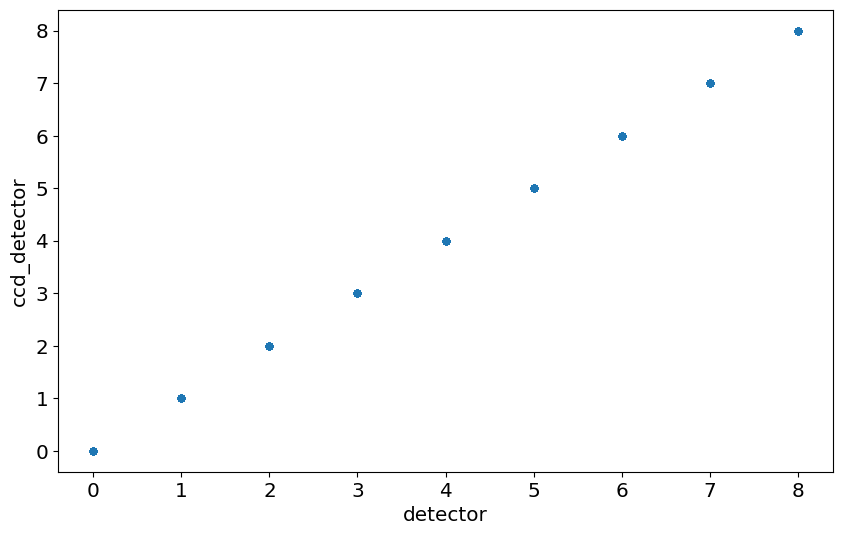

In [87]:
dataJoined.plot.scatter(x="detector",y="ccd_detector") 

<Axes: xlabel='visit', ylabel='ccd_visitId'>

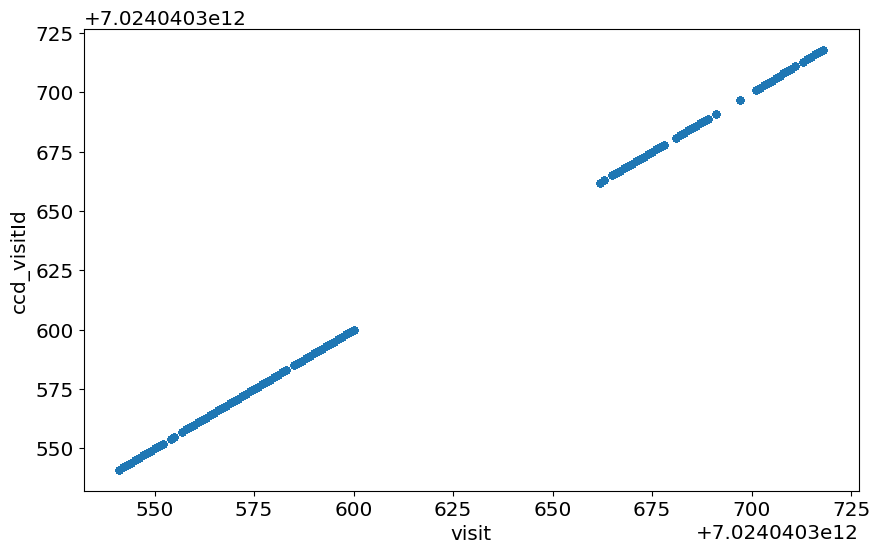

In [88]:
dataJoined.plot.scatter(x="visit",y="ccd_visitId") 

In [89]:
# Add columns into dataJoined table to have them all in one place
#dataJoined["psfSn"] = dataJoined["psfFlux"]/dataJoined["psfFluxErr"]
#dataJoined["psfMag"] = (dataJoined["psfFlux"].values*u.nJy).to(u.ABmag).value
#dataJoined["psfMagErr"] = 2.5/np.log(10.0)*(dataJoined["psfFluxErr"].values/dataJoined["psfFlux"].values)

##dataJoined["apFlux_35_0_calFlux"] = dataJoined["apFlux_35_0_instFlux"]*dataJoined["localPhotoCalib"]
##dataJoined["apFlux_35_0_calFluxErr"] = dataJoined["apFlux_35_0_instFluxErr"]*dataJoined["localPhotoCalib"]
# This is the way to apply aperture corrections :
#dataJoined[calibFluxCalStr] = dataJoined[calibFluxStr]*dataJoined["localPhotoCalib"]
#dataJoined[calibFluxCalErrStr] = dataJoined[calibFluxErrStr]*dataJoined["localPhotoCalib"]

#dataJoined[calibFluxStr] = (dataJoined[calibFluxStr].values*u.nJy).to(u.ABmag).value
#dataJoined[calibFluxStr] = 2.5/np.log(10.0)*(dataJoined[calibFluxStr].values/dataJoined[calibFluxStr].values)
#dataJoined[calibFluxCalMagStr] = (dataJoined[calibFluxCalStr].values*u.nJy).to(u.ABmag).value
#dataJoined[calibFluxCalMagErrStr] = 2.5/np.log(10.0)*(dataJoined[calibFluxCalErrStr].values/dataJoined[calibFluxCalStr].values)

# NOTE: psfFlux is the fgcm calibrated flux.  I'm pretty sure you get the "instrumental" 
# flux by dividing psfFlux by the localPhotoCalib value.
#dataJoined["psfInstMag"] = ((dataJoined["psfFlux"].values/dataJoined["localPhotoCalib"].values)*u.nJy).to(u.ABmag).value
#dataJoined["psfGausFluxRatio"] = dataJoined["psfFlux"]/dataJoined["gaussianFlux"]

#dataJoined["psfSigma"] = dataJoined.apply(lambda x: psfSigmaDict[x["visit"]], axis=1)
#dataJoined["skyBg"] = dataJoined.apply(lambda x: skyBgDict[x["visit"]], axis=1)
#dataJoined["expTime"] = dataJoined.apply(lambda x: expTimeDict[x["visit"]], axis=1)
#dataJoined["expMidptMjd"] = dataJoined.apply(lambda x: expMidptMjdDict[x["visit"]], axis=1)
#dataJoined["nSource"] = dataJoined.apply(lambda x: nSourceDict[x["visit"]], axis=1)
#dataJoined["medianE"] = dataJoined.apply(lambda x: medianEDict[x["visit"]], axis=1)
#dataJoined["psfStarScaledDeltaSizeScatter"] = dataJoined.apply(lambda x: psfStarScaledDeltaSizeScatterDict[x["visit"]], axis=1)
#dataJoined["astromOffsetStd"] = dataJoined.apply(lambda x: astromOffsetStdDict[x["visit"]], axis=1)
#dataJoined["psfTraceRadiusDelta"] = dataJoined.apply(lambda x: psfTraceRadiusDeltaDict[x["visit"]], axis=1)

# I add the airmass and zero-point I want to keep here
#dataJoined["zeroPoint"] = dataJoined.apply(lambda x: zeroPointDict[x["visit"]], axis=1)
#dataJoined["localPhotoCalib"] = dataJoined.apply(lambda x: localPhotoCalibDict[x["visit"]], axis=1)
#dataJoined["airmass"] = dataJoined.apply(lambda x: airmassDict[x["visit"]], axis=1)
#dataJoined["seeing"] = dataJoined.apply(lambda x: seeingDict[x["visit"]], axis=1)
#dataJoined["DZP"] = dataJoined.apply(lambda x: DZPDict[x["visit"]], axis=1)

#matchedObjIdList = list(set(dataJoined["obj_index"]))

In [90]:
matchedObjIdList = list(set(dataJoined["obj_index"]))

In [91]:
dataJoined[dataJoined.index == 0]

,sourceId,psfFlux,psfFluxErr,psfFlux_flag,psfFlux_apCorr,psfFlux_apCorrErr,extendedness,detect_isPrimary,deblend_skipped,gaussianFlux,gaussianFluxErr,gaussianFlux_flag,localPhotoCalib,localPhotoCalibErr,localPhotoCalib_flag,index,visit,detector,ra,dec,physical_filter,band,apFlux_12_0_instFlux,apFlux_12_0_instFluxErr,x,y,xErr,yErr,apFlux_17_0_instFlux,apFlux_17_0_instFluxErr,apFlux_17_0_flag,localBackground_instFlux,localBackground_flag,ixx,iyy,ixy,source_row,obj_index,psfSn,psfMag,psfMagErr,apFlux_12_0_calFlux,apFlux_12_0_calFluxErr,apFlux_12_0_calMag,apFlux_12_0_calMagErr,psfInstMag,psfGausFluxRatio,ccd_ccdVisitId,ccd_visitId,ccd_band,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,decl,ccd_detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,airmass,medianE,dra,ddec
0,3065474186727129163,86352.630263,343.423668,False,0.997264,0.0,0.0,True,False,86489.062244,389.563021,False,1.149911,0.000253,False,74,7024040300544,0,279.618643,-47.84183,r_03,r,74523.492188,585.486816,1133.34122,49.511971,0.009525,0.009359,75142.562976,809.938955,False,2.240031,False,2.173527,2.154956,0.118756,74,6981,251.446357,19.059311,0.004318,85695.415844,673.257985,19.067606,0.00853,19.210972,0.998423,730865999872,7024040300544,r,40.529137,31.247652,1.469387,805.57782,26.311092,0.004505,0.002748,1706,0.000118,0.000035,0.011436,0.011227,-0.000496,0.009868,0.006708,0.010058,193.601685,25.691765,1.185681,0.729166,0.990555,-47.896521,0,0.69262,141.735855,2024-04-04 07:18:52.089492,60404.30477,30.0,2024-04-04 07:18:37.089492,60404.304596,33.0565,4071,3999,279.541915,-47.878287,279.807847,-47.739247,280.012109,-47.914275,279.745803,-48.053787,1.315659,0.000123,-0.158274,0.054691


## The association between the independent sources is done through the object index 

- for plotting the repeatability

In [92]:
# Compute repeatability related values per object/object group and add
# them inplace to the dataJoined DataFrame.
psfMagDiffMmagDfList = []
psfMagStdMmagAll = []
psfMagStdMmagDict = {}
psfMagDiffChiDfList = []
psfSnAll = []
raDiffMasDfList = []
decDiffMasDfList = []
raCosDecDiffMasDfList = []
objRaDegList = []
objDecDegList = []
raStdMasAll = []
decStdMasAll = []
raCosDecStdMasAll = []
objDataList = []

# loop on objects
for objIndex in matchedObjIdList:
    # select sources corresponding to that object
    objData = dataJoined[dataJoined["obj_index"] == objIndex]
    psfMag = objData["psfMag"]
    psfMagErr = objData["psfMagErr"]

    # average flux over all visits
    clippedMeanMagArray = scipy.stats.sigmaclip(psfMag, low=3.0, high=3.0).clipped
    clippedMeanMag = np.mean(clippedMeanMagArray)
    clippedMeanMagErr = np.std(clippedMeanMagArray)/np.sqrt(len(clippedMeanMagArray))

    # array of difference between flux an clipped mean average
    psfMagDiffMmag = 1000*(psfMag - clippedMeanMag)
    # sigma arrays over the difference
    psfMagStdMmag = np.std(psfMagDiffMmag)
    # residuals array
    psfMagDiffChi = (psfMag - clippedMeanMag)/np.sqrt(psfMagErr**2 + clippedMeanMagErr**2)
    
    clippedMeanRaArray = scipy.stats.sigmaclip(objData["ra"], low=3.0, high=3.0).clipped
    clippedMeanRa = np.mean(clippedMeanRaArray)
    raDiffMas = (objData["ra"] - clippedMeanRa)*3600*1000
    
    clippedMeanDecArray = scipy.stats.sigmaclip(objData["dec"], low=3.0, high=3.0).clipped
    clippedMeanDec = np.mean(clippedMeanDecArray)
    decDiffMas = (objData["dec"] - clippedMeanDec)*3600*1000
    
    raCosDec = np.deg2rad(objData["ra"])*np.cos(np.deg2rad(objData["dec"]))
    clippedMeanRaCosDecArray = scipy.stats.sigmaclip(raCosDec, low=3.0, high=3.0).clipped
    clippedMeanRaCosDec = np.mean(clippedMeanRaCosDecArray)
    raCosDecDiffRad = (raCosDec - clippedMeanRaCosDec)
    raCosDecDiffMas = np.rad2deg(raCosDecDiffRad)*3600*1000

    # save for all sources of the object
    psfMagDiffMmagDfList.append(psfMagDiffMmag)
    psfMagStdMmagAll.append(psfMagStdMmag)
    psfMagDiffChiDfList.append(psfMagDiffChi)

    raDiffMasDfList.append(raDiffMas)
    decDiffMasDfList.append(decDiffMas)
    raCosDecDiffMasDfList.append(raCosDecDiffMas)
    
    objRaDegList.append(clippedMeanRa)
    objDecDegList.append(clippedMeanDec)

    raStdMas = np.std(raDiffMas)
    raStdMasAll.append(raStdMas)
    decStdMas = np.std(decDiffMas)
    decStdMasAll.append(decStdMas)
    raCosDecStdMas = np.std(raCosDecDiffMas)
    raCosDecStdMasAll.append(raCosDecStdMas)
    psfMagStdMmagDict[objIndex] = psfMagStdMmag

# concatenate over all objects - all sources
psfMagDiffMmagDf = pd.concat(psfMagDiffMmagDfList)
psfMagDiffChiDf = pd.concat(psfMagDiffChiDfList)
raDiffMasDf = pd.concat(raDiffMasDfList)
decDiffMasDf = pd.concat(decDiffMasDfList)
raCosDecDiffMasDf = pd.concat(raCosDecDiffMasDfList)

# add this common properties to each source in dataJoined
dataJoined.loc[:, "psfMagDiffMmag"] = psfMagDiffMmagDf
dataJoined.loc[:, "psfMagDiffChi"] = psfMagDiffChiDf
dataJoined.loc[:, "raDiffMas"] = raDiffMasDf
dataJoined.loc[:, "decDiffMas"] = decDiffMasDf
dataJoined.loc[:, "raCosDecDiffMas"] = raCosDecDiffMasDf

In [93]:
dataJoined[dataJoined.index == 0]

,sourceId,psfFlux,psfFluxErr,psfFlux_flag,psfFlux_apCorr,psfFlux_apCorrErr,extendedness,detect_isPrimary,deblend_skipped,gaussianFlux,gaussianFluxErr,gaussianFlux_flag,localPhotoCalib,localPhotoCalibErr,localPhotoCalib_flag,index,visit,detector,ra,dec,physical_filter,band,apFlux_12_0_instFlux,apFlux_12_0_instFluxErr,x,y,xErr,yErr,apFlux_17_0_instFlux,apFlux_17_0_instFluxErr,apFlux_17_0_flag,localBackground_instFlux,localBackground_flag,ixx,iyy,ixy,source_row,obj_index,psfSn,psfMag,psfMagErr,apFlux_12_0_calFlux,apFlux_12_0_calFluxErr,apFlux_12_0_calMag,apFlux_12_0_calMagErr,psfInstMag,psfGausFluxRatio,ccd_ccdVisitId,ccd_visitId,ccd_band,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,decl,ccd_detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,airmass,medianE,dra,ddec,psfMagDiffMmag,psfMagDiffChi,raDiffMas,decDiffMas,raCosDecDiffMas
0,3065474186727129163,86352.630263,343.423668,False,0.997264,0.0,0.0,True,False,86489.062244,389.563021,False,1.149911,0.000253,False,74,7024040300544,0,279.618643,-47.84183,r_03,r,74523.492188,585.486816,1133.34122,49.511971,0.009525,0.009359,75142.562976,809.938955,False,2.240031,False,2.173527,2.154956,0.118756,74,6981,251.446357,19.059311,0.004318,85695.415844,673.257985,19.067606,0.00853,19.210972,0.998423,730865999872,7024040300544,r,40.529137,31.247652,1.469387,805.57782,26.311092,0.004505,0.002748,1706,0.000118,0.000035,0.011436,0.011227,-0.000496,0.009868,0.006708,0.010058,193.601685,25.691765,1.185681,0.729166,0.990555,-47.896521,0,0.69262,141.735855,2024-04-04 07:18:52.089492,60404.30477,30.0,2024-04-04 07:18:37.089492,60404.304596,33.0565,4071,3999,279.541915,-47.878287,279.807847,-47.739247,280.012109,-47.914275,279.745803,-48.053787,1.315659,0.000123,-0.158274,0.054691,-59.472362,-1.880536,10.08548,1.043184,10.543113


In [94]:
dataJoined.head()

,sourceId,psfFlux,psfFluxErr,psfFlux_flag,psfFlux_apCorr,psfFlux_apCorrErr,extendedness,detect_isPrimary,deblend_skipped,gaussianFlux,gaussianFluxErr,gaussianFlux_flag,localPhotoCalib,localPhotoCalibErr,localPhotoCalib_flag,index,visit,detector,ra,dec,physical_filter,band,apFlux_12_0_instFlux,apFlux_12_0_instFluxErr,x,y,xErr,yErr,apFlux_17_0_instFlux,apFlux_17_0_instFluxErr,apFlux_17_0_flag,localBackground_instFlux,localBackground_flag,ixx,iyy,ixy,source_row,obj_index,psfSn,psfMag,psfMagErr,apFlux_12_0_calFlux,apFlux_12_0_calFluxErr,apFlux_12_0_calMag,apFlux_12_0_calMagErr,psfInstMag,psfGausFluxRatio,ccd_ccdVisitId,ccd_visitId,ccd_band,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,decl,ccd_detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,airmass,medianE,dra,ddec,psfMagDiffMmag,psfMagDiffChi,raDiffMas,decDiffMas,raCosDecDiffMas
0,3065474186727129163,86352.630263,343.423668,False,0.997264,0.0,0.0,True,False,86489.062244,389.563021,False,1.149911,0.000253,False,74,7024040300544,0,279.618643,-47.841830,r_03,r,74523.492188,585.486816,1133.341220,49.511971,0.009525,0.009359,75142.562976,809.938955,False,2.240031,False,2.173527,2.154956,0.118756,74,6981,251.446357,19.059311,0.004318,85695.415844,673.257985,19.067606,0.008530,19.210972,0.998423,730865999872,7024040300544,r,40.529137,31.247652,1.469387,805.57782,26.311092,0.004505,0.002748,1706,0.000118,0.000035,0.011436,0.011227,-0.000496,0.009868,0.006708,0.010058,193.601685,25.691765,1.185681,0.729166,0.990555,-47.896521,0,0.69262,141.735855,2024-04-04 07:18:52.089492,60404.30477,30.0,2024-04-04 07:18:37.089492,60404.304596,33.0565,4071,3999,279.541915,-47.878287,279.807847,-47.739247,280.012109,-47.914275,279.745803,-48.053787,1.315659,0.000123,-0.158274,0.054691,-59.472362,-1.880536,10.085480,1.043184,10.543113
1,3065474186727129197,271502.836115,559.213775,False,0.996407,0.0,0.0,True,False,271045.523679,602.357251,False,1.149843,0.000253,False,108,7024040300544,0,279.571242,-47.867834,r_03,r,235866.250000,647.441223,394.436554,67.906204,0.004729,0.004773,235919.239465,841.260489,False,0.885346,False,2.175947,2.131584,0.077974,108,6781,485.508134,17.815564,0.002236,271209.059682,744.455493,17.816740,0.002980,17.967160,1.001687,730865999872,7024040300544,r,40.529137,31.247652,1.469387,805.57782,26.311092,0.004505,0.002748,1706,0.000118,0.000035,0.011436,0.011227,-0.000496,0.009868,0.006708,0.010058,193.601685,25.691765,1.185681,0.729166,0.990555,-47.896521,0,0.69262,141.735855,2024-04-04 07:18:52.089492,60404.30477,30.0,2024-04-04 07:18:37.089492,60404.304596,33.0565,4071,3999,279.541915,-47.878287,279.807847,-47.739247,280.012109,-47.914275,279.745803,-48.053787,1.315659,0.000123,-0.205676,0.028687,-65.538373,-1.749445,-6.297338,-2.029341,-11.567875
2,3065474186727129203,141491.975535,419.970572,False,0.998635,0.0,0.0,True,False,143010.959664,509.324189,False,1.150249,0.000253,False,114,7024040300544,0,279.701450,-47.800154,r_03,r,123315.273438,617.954712,2383.222187,72.111413,0.007018,0.006967,123525.561704,837.931714,False,0.857274,False,2.227604,2.179145,0.108400,114,3396,336.909262,18.523170,0.003223,141843.307550,710.801978,18.520478,0.005441,18.675150,0.989379,730865999872,7024040300544,r,40.529137,31.247652,1.469387,805.57782,26.311092,0.004505,0.002748,1706,0.000118,0.000035,0.011436,0.011227,-0.000496,0.009868,0.006708,0.010058,193.601685,25.691765,1.185681,0.729166,0.990555,-47.896521,0,0.69262,141.735855,2024-04-04 07:18:52.089492,60404.30477,30.0,2024-04-04 07:18:37.089492,60404.304596,33.0565,4071,3999,279.541915,-47.878287,279.807847,-47.739247,280.012109,

## Check the correlation between the flux psf and apperture flux

### Compute DPZ

In [95]:
dataJoined["localPhotoCalibMag"] = (dataJoined["localPhotoCalib"].values*u.nJy).to(u.ABmag).value
dataJoined["localPhotoCalibMagErr"] =   2.5/np.log(10.0)*dataJoined["localPhotoCalibErr"].values/dataJoined["localPhotoCalib"].values
dataJoined["DZP"] = dataJoined["localPhotoCalibMag"] - dataJoined["zeroPoint"]

- The goal is to understand what flux is calibrated what flux is not calibrated 

In [96]:
dataJoined_subset = dataJoined[["obj_index","sourceId","band","visit","ra","dec","psfMag","psfFlux","gaussianFlux",calibFluxCalStr,calibFluxCalMagStr,calibFluxStr,"psfFlux_apCorr",
                                "psfMagErr","psfFluxErr","gaussianFluxErr",calibFluxCalErrStr,calibFluxCalMagErrStr,calibFluxErrStr,"skyBg","zeroPoint","localPhotoCalib","localPhotoCalibMag","DZP","localPhotoCalibMagErr","airmass","seeing","detector","x","y"]].copy()

In [97]:
dataJoined_subset.sort_values(by=["obj_index","band","visit"])

,obj_index,sourceId,band,visit,ra,dec,psfMag,psfFlux,gaussianFlux,apFlux_12_0_calFlux,apFlux_12_0_calMag,apFlux_12_0_instFlux,psfFlux_apCorr,psfMagErr,psfFluxErr,gaussianFluxErr,apFlux_12_0_calFluxErr,apFlux_12_0_calMagErr,apFlux_12_0_instFluxErr,skyBg,zeroPoint,localPhotoCalib,localPhotoCalibMag,DZP,localPhotoCalibMagErr,airmass,seeing,detector,x,y
33275,2,3065474205010100900,g,7024040300561,279.861514,-48.062470,17.407479,395374.205434,395940.291625,397128.435355,17.402673,389630.625000,1.002165,0.001706,621.280054,693.248386,664.535860,0.001817,651.989380,488.987274,31.379395,1.019243,31.379305,-0.000089,0.000266,1.275090,0.767376,7,2613.686424,460.662027
34846,2,3065474206067067645,g,7024040300562,279.861518,-48.062470,17.407384,395408.771854,396104.055798,396718.992082,17.403793,382041.062500,1.000496,0.001716,625.116694,681.577932,651.310139,0.001782,627.212769,479.765320,31.358877,1.038420,31.359068,0.000190,0.000271,1.271673,0.758476,3,3640.986647,1930.369395
40997,2,3065474208218746853,g,7024040300564,279.861514,-48.062470,17.403342,396883.469674,396739.499983,396860.844933,17.403404,385678.281250,0.997478,0.001711,625.600130,689.829827,638.997381,0.001748,620.992004,484.307617,31.368658,1.028995,31.368967,0.000309,0.000281,1.267434,0.803705,4,3598.982275,2898.519283
43991,2,3065474209292486158,g,7024040300565,279.861514,-48.062469,17.410636,394226.164905,395150.224049,394913.050799,17.408746,383981.656250,1.000594,0.001715,622.810508,713.196634,649.583337,0.001786,631.602539,485.573364,31.369371,1.028469,31.369522,0.000151,0.000271,1.269254,0.807031,4,101.553695,1065.669406
47038,2,3065474210366230144,g,7024040300566,279.861514,-48.062469,17.404488,396465.041320,396046.108383,396323.516568,17.404875,385106.250000,0.997942,0.001714,625.812197,721.292789,645.350892,0.001768,627.085327,484.862000,31.368828,1.029128,31.368827,-0.000001,0.000284,1.264753,0.812970,4,2318.735023,2625.236629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61533,27487,3065474217890810739,g,7024040300573,279.676455,-48.147935,16.735981,733850.432032,728289.566931,730239.263640,16.741337,700754.750000,0.999916,0.001275,861.990883,1005.083615,807.130622,0.001200,774.541504,476.512207,31.355286,1.042075,31.355252,-0.000033,0.000271,1.251249,0.773395,6,791.389830,2044.494164
160891,27487,3065474337080347088,g,7024040300684,279.676451,-48.147934,16.739530,731455.413356,725701.082847,727847.847238,16.744898,735399.562500,0.997988,0.001249,841.502608,1006.830216,798.786064,0.001192,807.073792,489.432159,31.411200,0.989731,31.411207,0.000007,0.000258,1.086959,0.762471,7,1575.308003,1717.451917
47887,27499,3065474210374620409,g,7024040300566,279.613615,-48.415778,18.840245,105657.885569,105512.634962,105735.433137,18.839449,100986.148438,0.998573,0.003525,343.054395,398.864488,512.692348,0.005265,489.663910,475.047577,31.350706,1.047029,31.350103,-0.000603,0.000258,1.262846,0.814498,6,2219.450518,3922.412088
59004,27499,3065474216817066146,g,7024040300572,279.613613,-48.415778,18.847505,104953.736515,105251.637009,104503.850774,18.852169,100025.484375,0.999526,0.003513,339.622003,354.900773,517.213344,0.005374,495.048889,475.339600,31.352852,1.044772,31.352446,-0.000406,0.000383,1.254673,0.780577,6,460.902437,115.863467


In [98]:
dataJoined_subset_g = dataJoined_subset[dataJoined_subset["band"] == "g"]
dataJoined_subset_r = dataJoined_subset[dataJoined_subset["band"] == "r"]
dataJoined_subset_i = dataJoined_subset[dataJoined_subset["band"] == "i"]
dataJoined_subset_z = dataJoined_subset[dataJoined_subset["band"] == "z"]
dataJoined_subset_y = dataJoined_subset[dataJoined_subset["band"] == "y"]

### Histogram on calibration

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


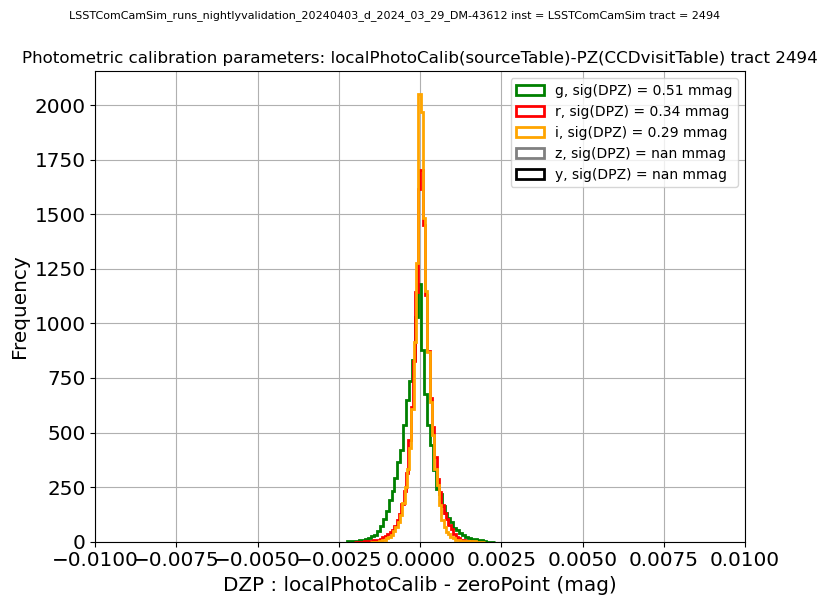

In [99]:
all_dpz_std = []
all_labels = []
fig,ax = plt.subplots(1,1,figsize=(8,6))

std = dataJoined_subset_g["DZP"].std()*1000
label = f"g, sig(DPZ) = {std:.2f} mmag"
all_dpz_std.append(std)
all_labels.append(label) 
dataJoined_subset_g["DZP"].plot.hist(bins=50,histtype="step",density=True,ax=ax,color="g",lw=2,label=label)

std = dataJoined_subset_r["DZP"].std()*1000
label = f"r, sig(DPZ) = {std:.2f} mmag"
all_dpz_std.append(std)
all_labels.append(label) 
dataJoined_subset_r["DZP"].plot.hist(bins=50,histtype="step",density=True,ax=ax,color="r",lw=2,label=label)

std = dataJoined_subset_i["DZP"].std()*1000
label = f"i, sig(DPZ) = {std:.2f} mmag"
all_dpz_std.append(std)
all_labels.append(label) 
dataJoined_subset_i["DZP"].plot.hist(bins=50,histtype="step",density=True,ax=ax,color="orange",lw=2,label=label)

std = dataJoined_subset_z["DZP"].std()*1000
label = f"z, sig(DPZ) = {std:.2f} mmag"
all_dpz_std.append(std)
all_labels.append(label) 
dataJoined_subset_z["DZP"].plot.hist(bins=50,histtype="step",density=True,ax=ax,color="grey",lw=2,label=label)

std = dataJoined_subset_y["DZP"].std()*1000
label = f"y, sig(DPZ) = {std:.2f} mmag"
all_dpz_std.append(std)
all_labels.append(label) 
dataJoined_subset_y["DZP"].plot.hist(bins=50,histtype="step",density=True,ax=ax,color="k",lw=2,label=label)

ax.set_xlabel("DZP : localPhotoCalib - zeroPoint (mag)")
ax.set_xlim(-0.01,0.01)
ax.grid()
ax.legend()
ax.set_title(f"Photometric calibration parameters: localPhotoCalib(sourceTable)-PZ(CCDvisitTable) tract {tract}",fontsize=12)
plt.suptitle(suptitle,y=1.0,fontsize=8)
plt.tight_layout()

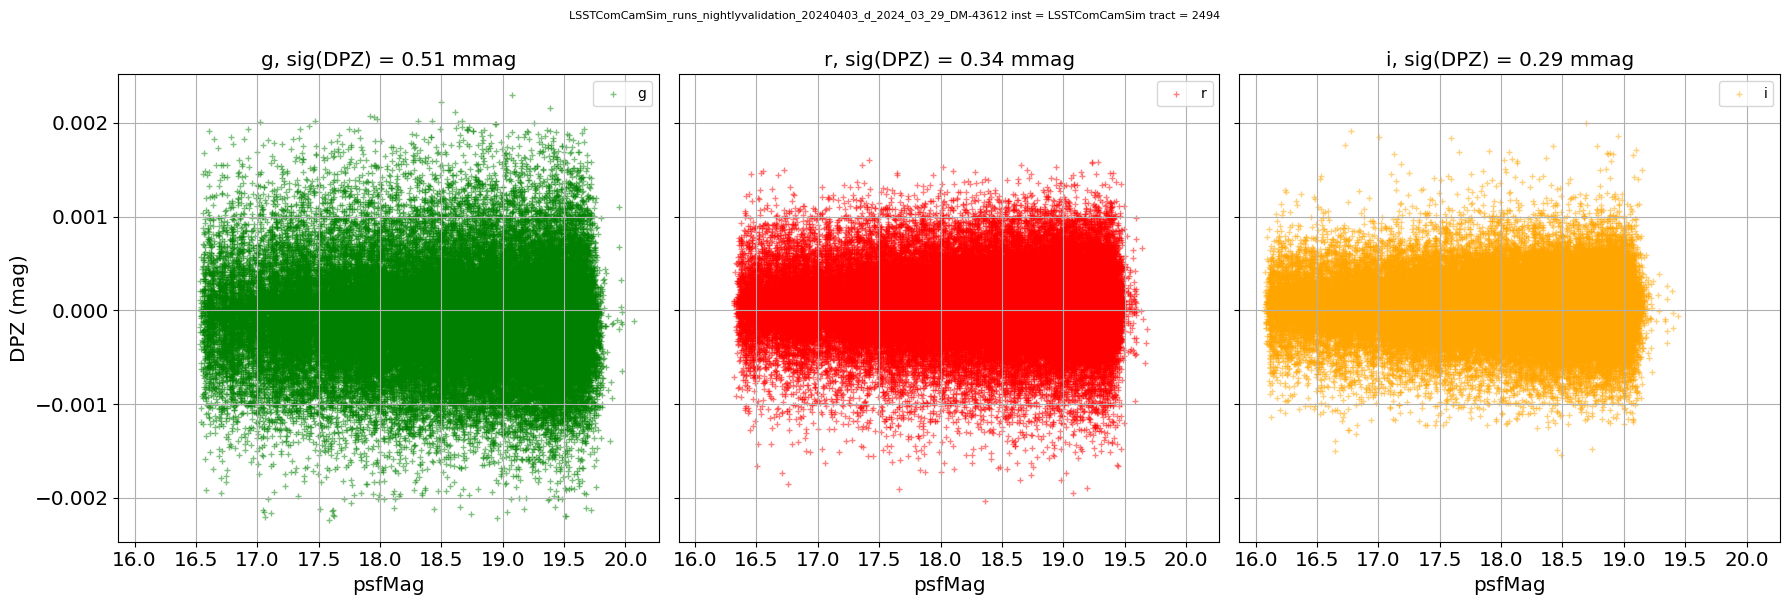

In [100]:
fig,axs = plt.subplots(1,3,figsize=(18,6),sharex=True,sharey=True)
#ax1,ax2,ax3,ax4,ax5 =axs
ax1,ax2,ax3 =axs
dataJoined_subset_g.plot.scatter(x="psfMag",y="DZP",ax=ax1,color="g",marker="+",lw=1,label="g",title=all_labels[0],grid=True,alpha=0.5)
dataJoined_subset_r.plot.scatter(x="psfMag",y="DZP",ax=ax2,color="r",marker="+",lw=1,label="r",title=all_labels[1],grid=True,alpha=0.5)
dataJoined_subset_i.plot.scatter(x="psfMag",y="DZP",ax=ax3,color="orange",marker="+",lw=1,label="i",title=all_labels[2],grid=True,alpha=0.5)
#dataJoined_subset_z.plot.scatter(x="psfMag",y="DZP",ax=ax4,color="grey",marker="+",lw=0.5,label="z",title=all_labels[3],grid=True,alpha=0.5)
#dataJoined_subset_y.plot.scatter(x="psfMag",y="DZP",ax=ax5,color="k",marker="+",lw=0.5,label="y",title=all_labels[4],grid=True,alpha=0.5)
ax1.set_ylabel("DPZ (mag)")
plt.suptitle(suptitle,y=1.0,fontsize=8)
plt.tight_layout()

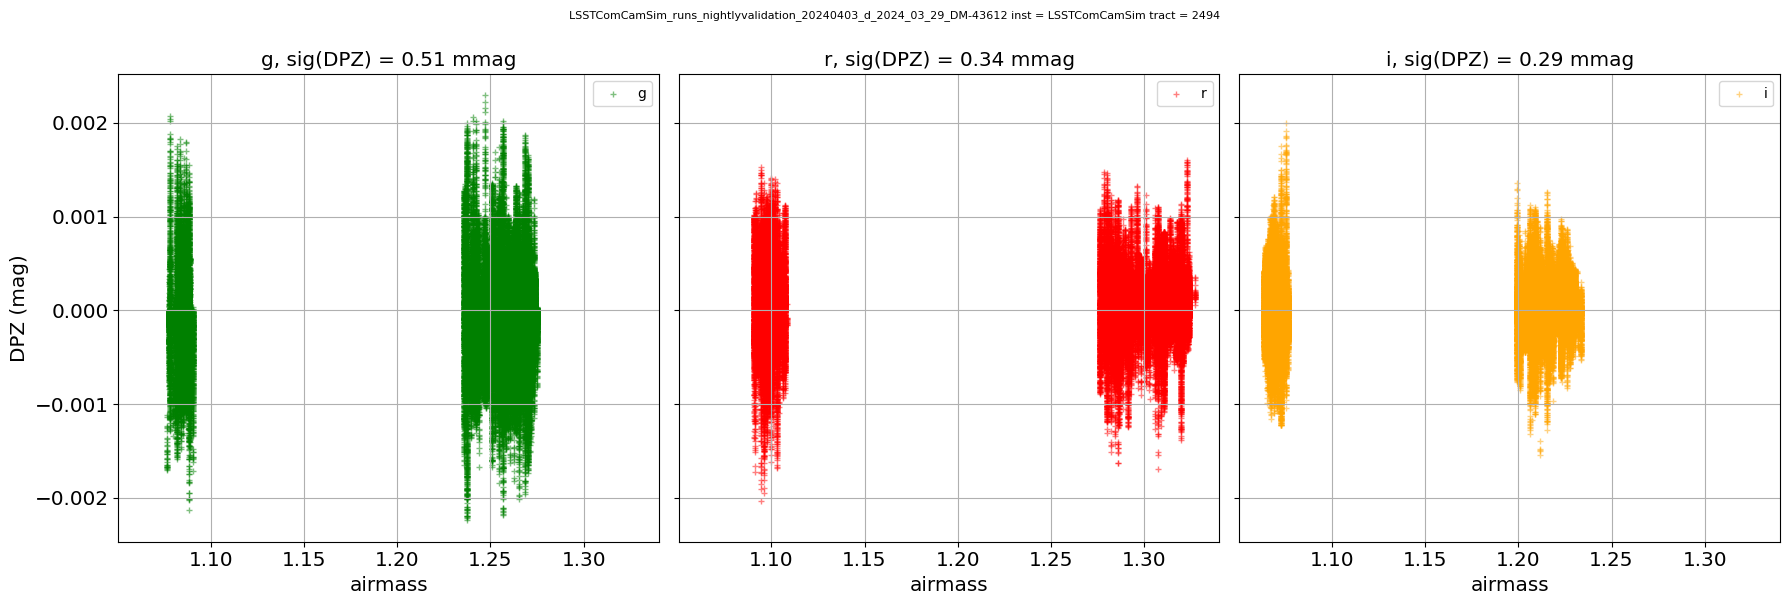

In [101]:
fig,axs = plt.subplots(1,3,figsize=(18,6),sharex=True,sharey=True)
#ax1,ax2,ax3,ax4,ax5 =axs
ax1,ax2,ax3 =axs
dataJoined_subset_g.plot.scatter(x="airmass",y="DZP",ax=ax1,color="g",marker="+",lw=1,label="g",title=all_labels[0],grid=True,alpha=0.5)
dataJoined_subset_r.plot.scatter(x="airmass",y="DZP",ax=ax2,color="r",marker="+",lw=1,label="r",title=all_labels[1],grid=True,alpha=0.5)
dataJoined_subset_i.plot.scatter(x="airmass",y="DZP",ax=ax3,color="orange",marker="+",lw=1,label="i",title=all_labels[2],grid=True,alpha=0.5)
#dataJoined_subset_z.plot.scatter(x="airmass",y="DZP",ax=ax4,color="grey",marker="+",lw=0.5,label="z",title=all_labels[3],grid=True,alpha=0.5)
#dataJoined_subset_y.plot.scatter(x="airmass",y="DZP",ax=ax5,color="k",marker="+",lw=0.5,label="y",title=all_labels[4],grid=True,alpha=0.5)
ax1.set_ylabel("DPZ (mag)")
plt.suptitle(suptitle,y=1.0,fontsize=8)
plt.tight_layout()

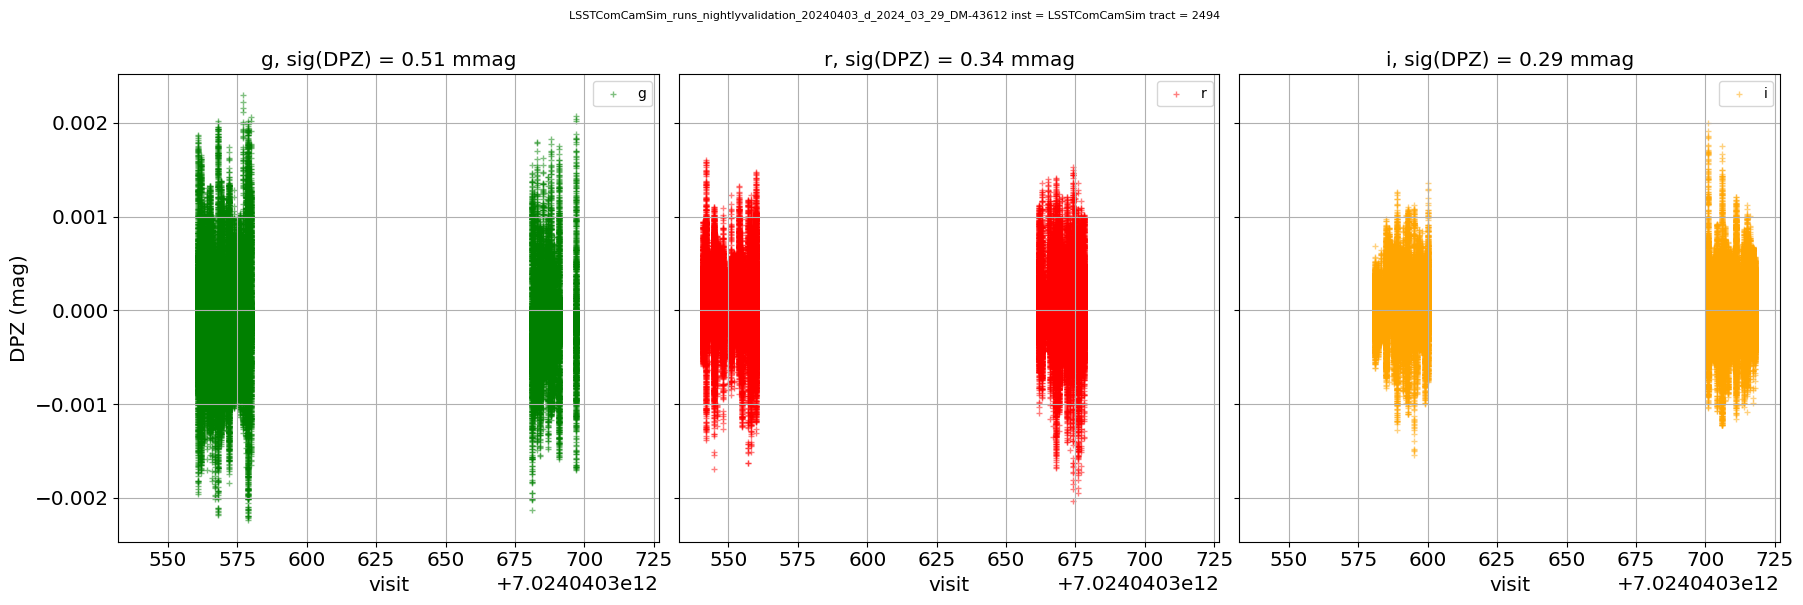

In [102]:
fig,axs = plt.subplots(1,3,figsize=(18,6),sharex=True,sharey=True)
#ax1,ax2,ax3,ax4,ax5 =axs
ax1,ax2,ax3 = axs
dataJoined_subset_g.plot.scatter(x="visit",y="DZP",ax=ax1,color="g",marker="+",lw=1,label="g",title=all_labels[0],grid=True,alpha=0.5)
dataJoined_subset_r.plot.scatter(x="visit",y="DZP",ax=ax2,color="r",marker="+",lw=1,label="r",title=all_labels[1],grid=True,alpha=0.5)
dataJoined_subset_i.plot.scatter(x="visit",y="DZP",ax=ax3,color="orange",marker="+",lw=1,label="i",title=all_labels[2],grid=True,alpha=0.5)
#dataJoined_subset_z.plot.scatter(x="visit",y="DZP",ax=ax4,color="grey",marker="+",lw=0.5,label="z",title=all_labels[3],grid=True,alpha=0.5)
#dataJoined_subset_y.plot.scatter(x="visit",y="DZP",ax=ax5,color="k",marker="+",lw=0.5,label="y",title=all_labels[4],grid=True,alpha=0.5)
ax1.set_ylabel("DPZ (mag)")
plt.suptitle(suptitle,y=1.0,fontsize=8)
plt.tight_layout()

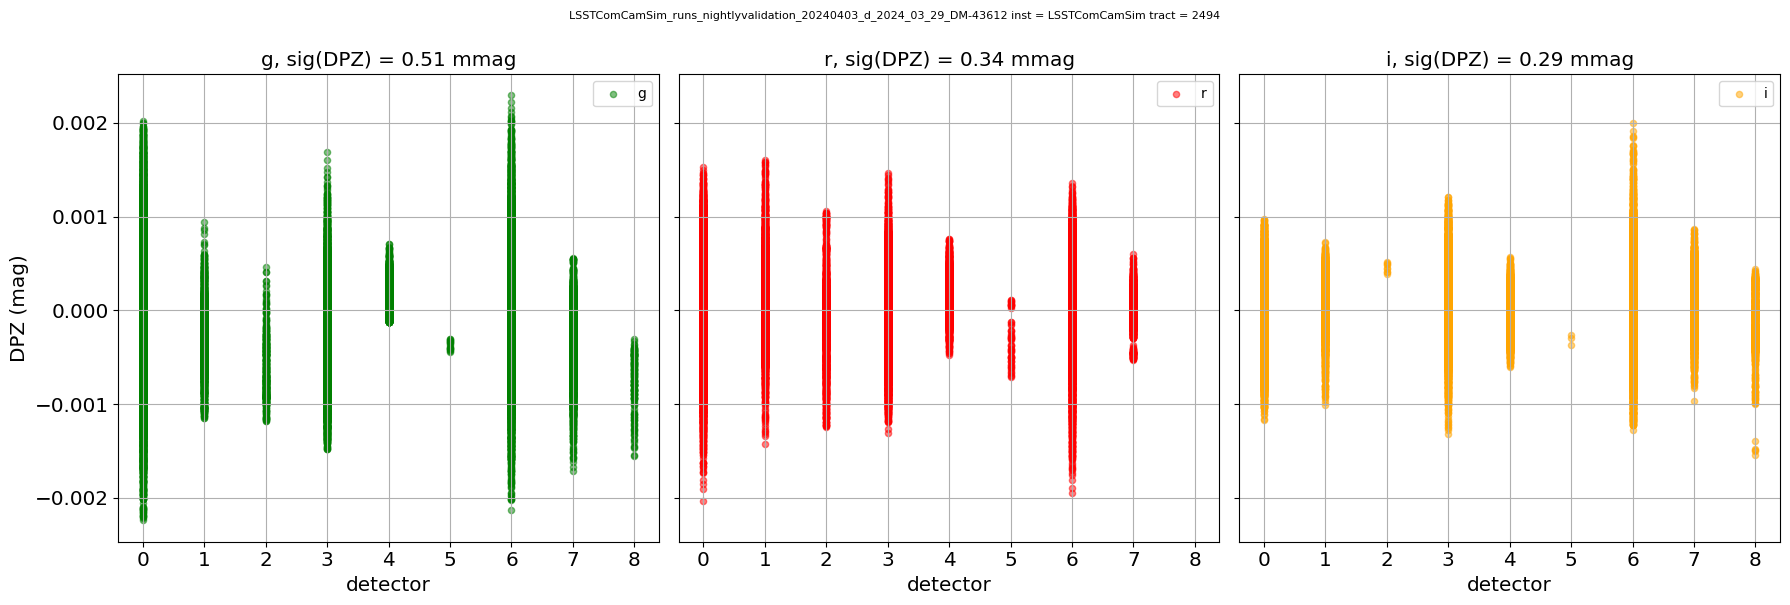

In [103]:
fig,axs = plt.subplots(1,3,figsize=(18,6),sharex=True,sharey=True)
#ax1,ax2,ax3,ax4,ax5 =axs
ax1,ax2,ax3 =axs
dataJoined_subset_g.plot.scatter(x="detector",y="DZP",ax=ax1,color="g",marker="o",lw=1,label="g",title=all_labels[0],grid=True,alpha=0.5)
dataJoined_subset_r.plot.scatter(x="detector",y="DZP",ax=ax2,color="r",marker="o",lw=1,label="r",title=all_labels[1],grid=True,alpha=0.5)
dataJoined_subset_i.plot.scatter(x="detector",y="DZP",ax=ax3,color="orange",marker="o",lw=1,label="i",title=all_labels[2],grid=True,alpha=0.5)
#dataJoined_subset_z.plot.scatter(x="detector",y="DZP",ax=ax4,color="grey",marker="o",lw=0.5,label="z",title=all_labels[3],grid=True,alpha=0.5)
#dataJoined_subset_y.plot.scatter(x="detector",y="DZP",ax=ax5,color="k",marker="o",lw=0.5,label="y",title=all_labels[4],grid=True,alpha=0.5)
ax1.set_ylabel("DPZ (mag)")
plt.suptitle(suptitle,y=1.0,fontsize=8)
plt.tight_layout()

In [104]:
all_localPhotoCalibMagErr_aver = []
all_labels = []

aver = dataJoined_subset_g["localPhotoCalibMagErr"].mean()*1000
label = f"g, aver(locPCalErr) = {aver:.2f} mmag"
all_localPhotoCalibMagErr_aver.append(std)
all_labels.append(label) 

aver = dataJoined_subset_r["localPhotoCalibMagErr"].mean()*1000
label = f"r, aver(locPCalErr) = {aver:.2f} mmag"
all_localPhotoCalibMagErr_aver.append(std)
all_labels.append(label) 

aver = dataJoined_subset_i["localPhotoCalibMagErr"].mean()*1000
label = f"i, aver(locPCalErr) = {aver:.2f} mmag"
all_localPhotoCalibMagErr_aver.append(std)
all_labels.append(label) 

aver = dataJoined_subset_z["localPhotoCalibMagErr"].mean()*1000
label = f"z, aver(locPCalErr) = {aver:.2f} mmag"
all_localPhotoCalibMagErr_aver.append(std)
all_labels.append(label) 

aver = dataJoined_subset_y["localPhotoCalibMagErr"].mean()*1000
label = f"y, aver(locPCalErr) = {aver:.2f} mmag"
all_localPhotoCalibMagErr_aver.append(std)
all_labels.append(label) 

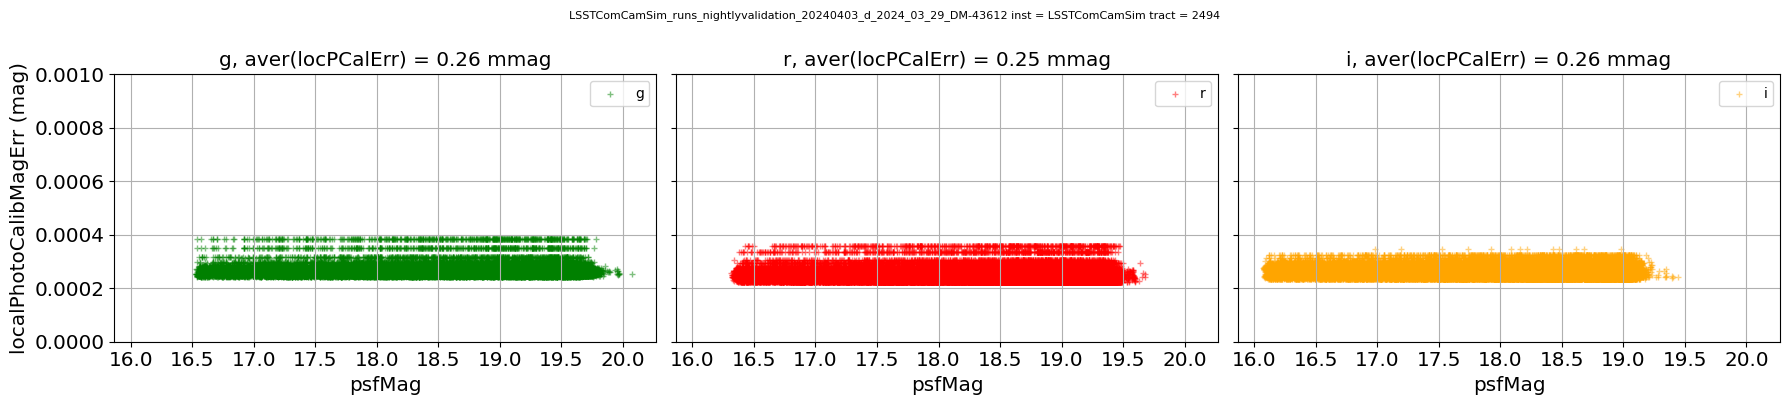

In [105]:
fig,axs = plt.subplots(1,3,figsize=(18,4),sharex=True,sharey=True)
#ax1,ax2,ax3,ax4,ax5 =axs
ax1,ax2,ax3 =axs
dataJoined_subset_g.plot.scatter(x="psfMag",y="localPhotoCalibMagErr",ax=ax1,color="g",marker="+",lw=1,label="g",title=all_labels[0],grid=True,alpha=0.5)
dataJoined_subset_r.plot.scatter(x="psfMag",y="localPhotoCalibMagErr",ax=ax2,color="r",marker="+",lw=1,label="r",title=all_labels[1],grid=True,alpha=0.5)
dataJoined_subset_i.plot.scatter(x="psfMag",y="localPhotoCalibMagErr",ax=ax3,color="orange",marker="+",lw=1,label="i",title=all_labels[2],grid=True,alpha=0.5)
#dataJoined_subset_z.plot.scatter(x="psfMag",y="localPhotoCalibMagErr",ax=ax4,color="grey",marker="+",lw=0.5,label="z",title=all_labels[3],grid=True,alpha=0.5)
#dataJoined_subset_y.plot.scatter(x="psfMag",y="localPhotoCalibMagErr",ax=ax5,color="k",marker="+",lw=0.5,label="y",title=all_labels[4],grid=True,alpha=0.5)
ax1.set_ylabel("localPhotoCalibMagErr (mag)")
ax1.set_ylim(0.,0.001)
plt.suptitle(suptitle,y=1.0,fontsize=8)
plt.tight_layout()

In [106]:
NDET

9

In [107]:
all_det_colors

[(0.86, 0.3712, 0.33999999999999997),
 (0.86, 0.7178666666666667, 0.33999999999999997),
 (0.6554666666666664, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.3712),
 (0.33999999999999997, 0.86, 0.7178666666666667),
 (0.33999999999999997, 0.6554666666666664, 0.86),
 (0.3712, 0.33999999999999997, 0.86),
 (0.7178666666666661, 0.33999999999999997, 0.86),
 (0.86, 0.33999999999999997, 0.6554666666666664)]

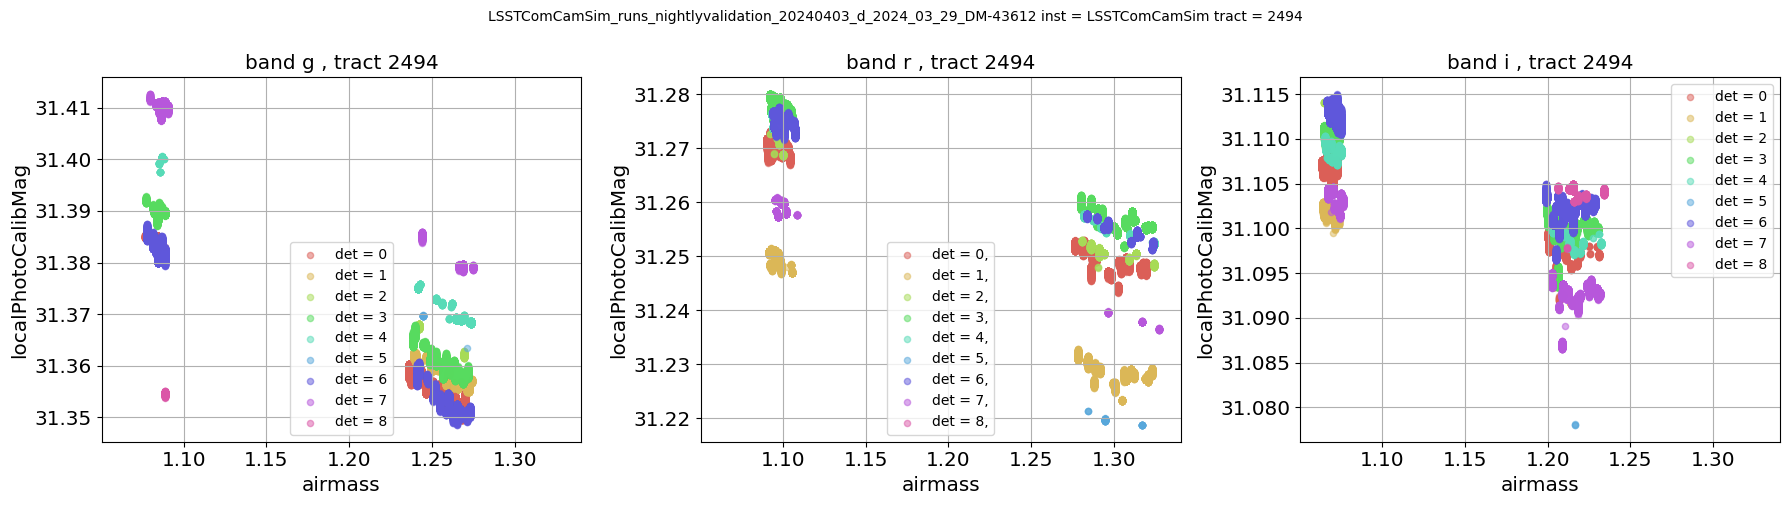

In [108]:
fig,axs = plt.subplots(1,3,figsize=(18,5),sharex=True,sharey=False)
#ax1,ax2,ax3,ax4,ax5 =axs
ax1,ax2,ax3 =axs
for idet in range(NDET):
    select_cut = dataJoined_subset_g["detector"] == idet
    the_color = all_det_colors[idet]
    the_label = f"det = {idet}"
    the_title = f"band g , tract {tract}"
    the_data = dataJoined_subset_g[select_cut]
    the_data.plot.scatter(x="airmass",y="localPhotoCalibMag",ax=ax1,color=the_color,marker="o",lw=1,label=the_label,title=the_title,grid=True,alpha=0.5)

for idet in range(NDET):
    select_cut = dataJoined_subset_r["detector"] == idet
    the_color = all_det_colors[idet]
    the_label = f"det = {idet},"
    the_title = f"band r , tract {tract}"
    the_data = dataJoined_subset_r[select_cut]
    the_data.plot.scatter(x="airmass",y="localPhotoCalibMag",ax=ax2,color=the_color,marker="o",lw=1,label=the_label,title=the_title,grid=True,alpha=0.5)

for idet in range(NDET):
    select_cut = dataJoined_subset_i["detector"] == idet
    the_color = all_det_colors[idet]
    the_label = f"det = {idet}"
    the_title = f"band i , tract {tract}"
    the_data = dataJoined_subset_i[select_cut]
    the_data.plot.scatter(x="airmass",y="localPhotoCalibMag",ax=ax3,color=the_color,marker="o",lw=1,label=the_label,title=the_title,grid=True,alpha=0.5)
    

#ax1.set_ylabel(f"localPhotoCalibMag (mag) for the different detectors (tract {tract})")
#ax1.set_ylim(0.,0.001)
plt.suptitle(suptitle,y=1.0,fontsize=10)
plt.tight_layout()

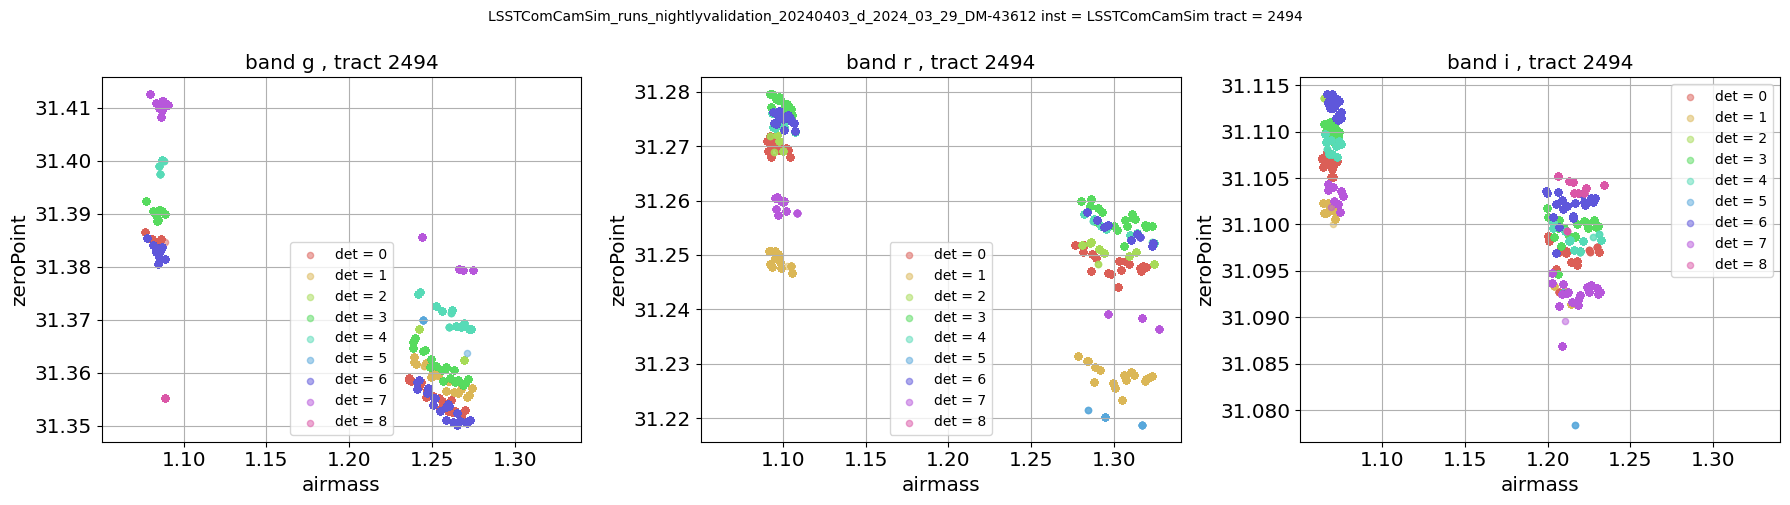

In [109]:
fig,axs = plt.subplots(1,3,figsize=(18,5),sharex=True,sharey=False)
#ax1,ax2,ax3,ax4,ax5 =axs
ax1,ax2,ax3 =axs
for idet in range(NDET):
    select_cut = dataJoined_subset_g["detector"] == idet
    the_color = all_det_colors[idet]
    the_label = f"det = {idet}"
    the_title = f"band g , tract {tract}"
    the_data = dataJoined_subset_g[select_cut]
    the_data.plot.scatter(x="airmass",y="zeroPoint",ax=ax1,color=the_color,marker="o",lw=1,label=the_label,title=the_title,grid=True,alpha=0.5)

for idet in range(NDET):
    select_cut = dataJoined_subset_r["detector"] == idet
    the_color = all_det_colors[idet]
    the_label = f"det = {idet}"
    the_title = f"band r , tract {tract}"
    the_data = dataJoined_subset_r[select_cut]
    the_data.plot.scatter(x="airmass",y="zeroPoint",ax=ax2,color=the_color,marker="o",lw=1,label=the_label,title=the_title,grid=True,alpha=0.5)

for idet in range(NDET):
    select_cut = dataJoined_subset_i["detector"] == idet
    the_color = all_det_colors[idet]
    the_label = f"det = {idet}"
    the_title = f"band i , tract {tract}"
    the_data = dataJoined_subset_i[select_cut]
    the_data.plot.scatter(x="airmass",y="zeroPoint",ax=ax3,color=the_color,marker="o",lw=1,label=the_label,title=the_title,grid=True,alpha=0.5)
    

#ax.set_title(f"zeroPoint (mag) for the different detectors (tract {tract})")
plt.suptitle(suptitle,y=1.0,fontsize=10)
plt.tight_layout()

## Non uniformity on CCD

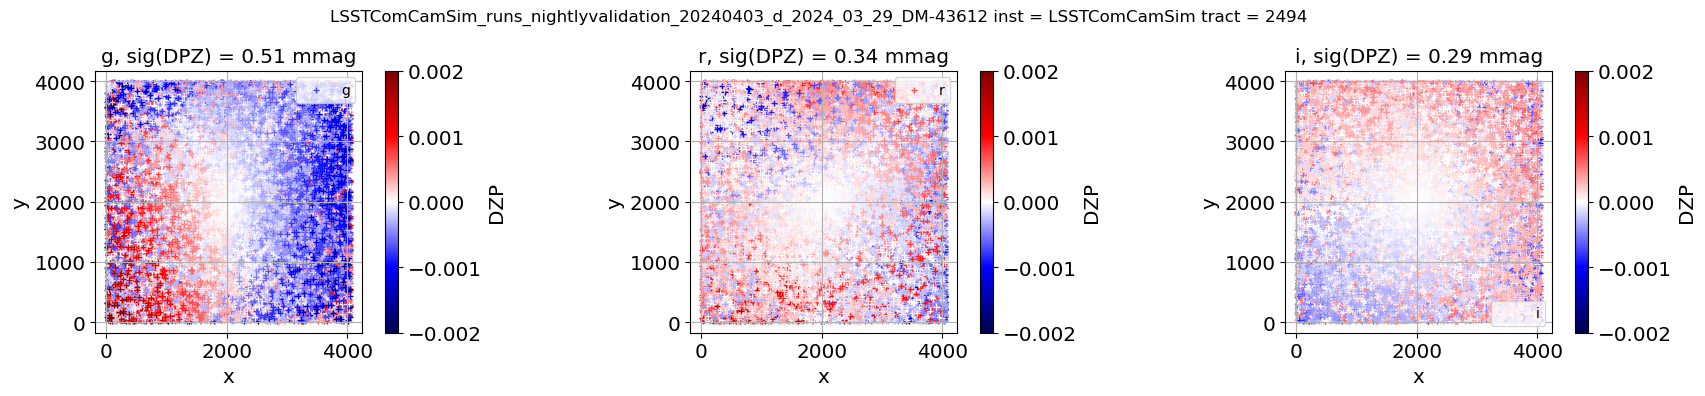

In [113]:
fig,axs = plt.subplots(1,3,figsize=(18,4))
ax1,ax2,ax3 = axs[0], axs[1],axs[2]

std = dataJoined_subset_g["DZP"].std()*1000
label = f"g, sig(DPZ) = {std:.2f} mmag"
dataJoined_subset_g.plot.scatter(x="x",y="y",ax=ax1,marker="+",lw=1,c="DZP",cmap="seismic",label="g",title=label,grid=True,alpha=1,colorbar="True",vmin=-0.002,vmax=0.002)
ax1.set_aspect("equal")

std = dataJoined_subset_r["DZP"].std()*1000
label = f"r, sig(DPZ) = {std:.2f} mmag"
dataJoined_subset_r.plot.scatter(x="x",y="y",ax=ax2,marker="+",lw=1,c="DZP",cmap="seismic",label="r",title=label,grid=True,alpha=1,colorbar="True",vmin=-0.002,vmax=0.002)
ax2.set_aspect("equal")

std = dataJoined_subset_i["DZP"].std()*1000
label = f"i, sig(DPZ) = {std:.2f} mmag"
dataJoined_subset_i.plot.scatter(x="x",y="y",ax=ax3,marker="+",lw=1,c="DZP",cmap="seismic",label="i",title=label,grid=True,alpha=1,colorbar="True",vmin=-0.002,vmax=0.002)
ax3.set_aspect("equal")




plt.suptitle(suptitle)
plt.tight_layout()